In [2]:

!pip install smartapi-python pandas numpy matplotlib pyotp logzero websocket-client pycryptodome
!pip install xgboost matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.1 MB/s eta 0:00:00


XGBoost (Extreme Gradient Boosting) is a supervised learning algorithm based on decision trees, optimized for performance using gradient boosting.


[I 250207 09:55:59 smartConnect:124] in pool
[I 250207 09:56:01 <ipython-input-11-bb3a868b3b1b>:44] ✅ Successfully logged in!
[I 250207 09:56:02 <ipython-input-11-bb3a868b3b1b>:68] ✅ Successfully fetched historical data!
[I 250207 09:56:02 <ipython-input-11-bb3a868b3b1b>:69]                   timestamp    open    high     low   close  volume
    0 2025-02-05 12:30:00+05:30  731.30  731.70  729.00  729.55   61983
    1 2025-02-05 12:31:00+05:30  729.85  730.50  729.40  729.40   29206
    2 2025-02-05 12:32:00+05:30  729.40  729.80  726.35  727.00   85824
    3 2025-02-05 12:33:00+05:30  726.65  728.85  725.55  728.65   89462
    4 2025-02-05 12:34:00+05:30  728.40  729.45  727.50  729.00   49496
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:56:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 250207 09:56:02 <ipython-input-11-bb3a868b3b1b>:84] Model Accuracy: 0.4000
[I 250

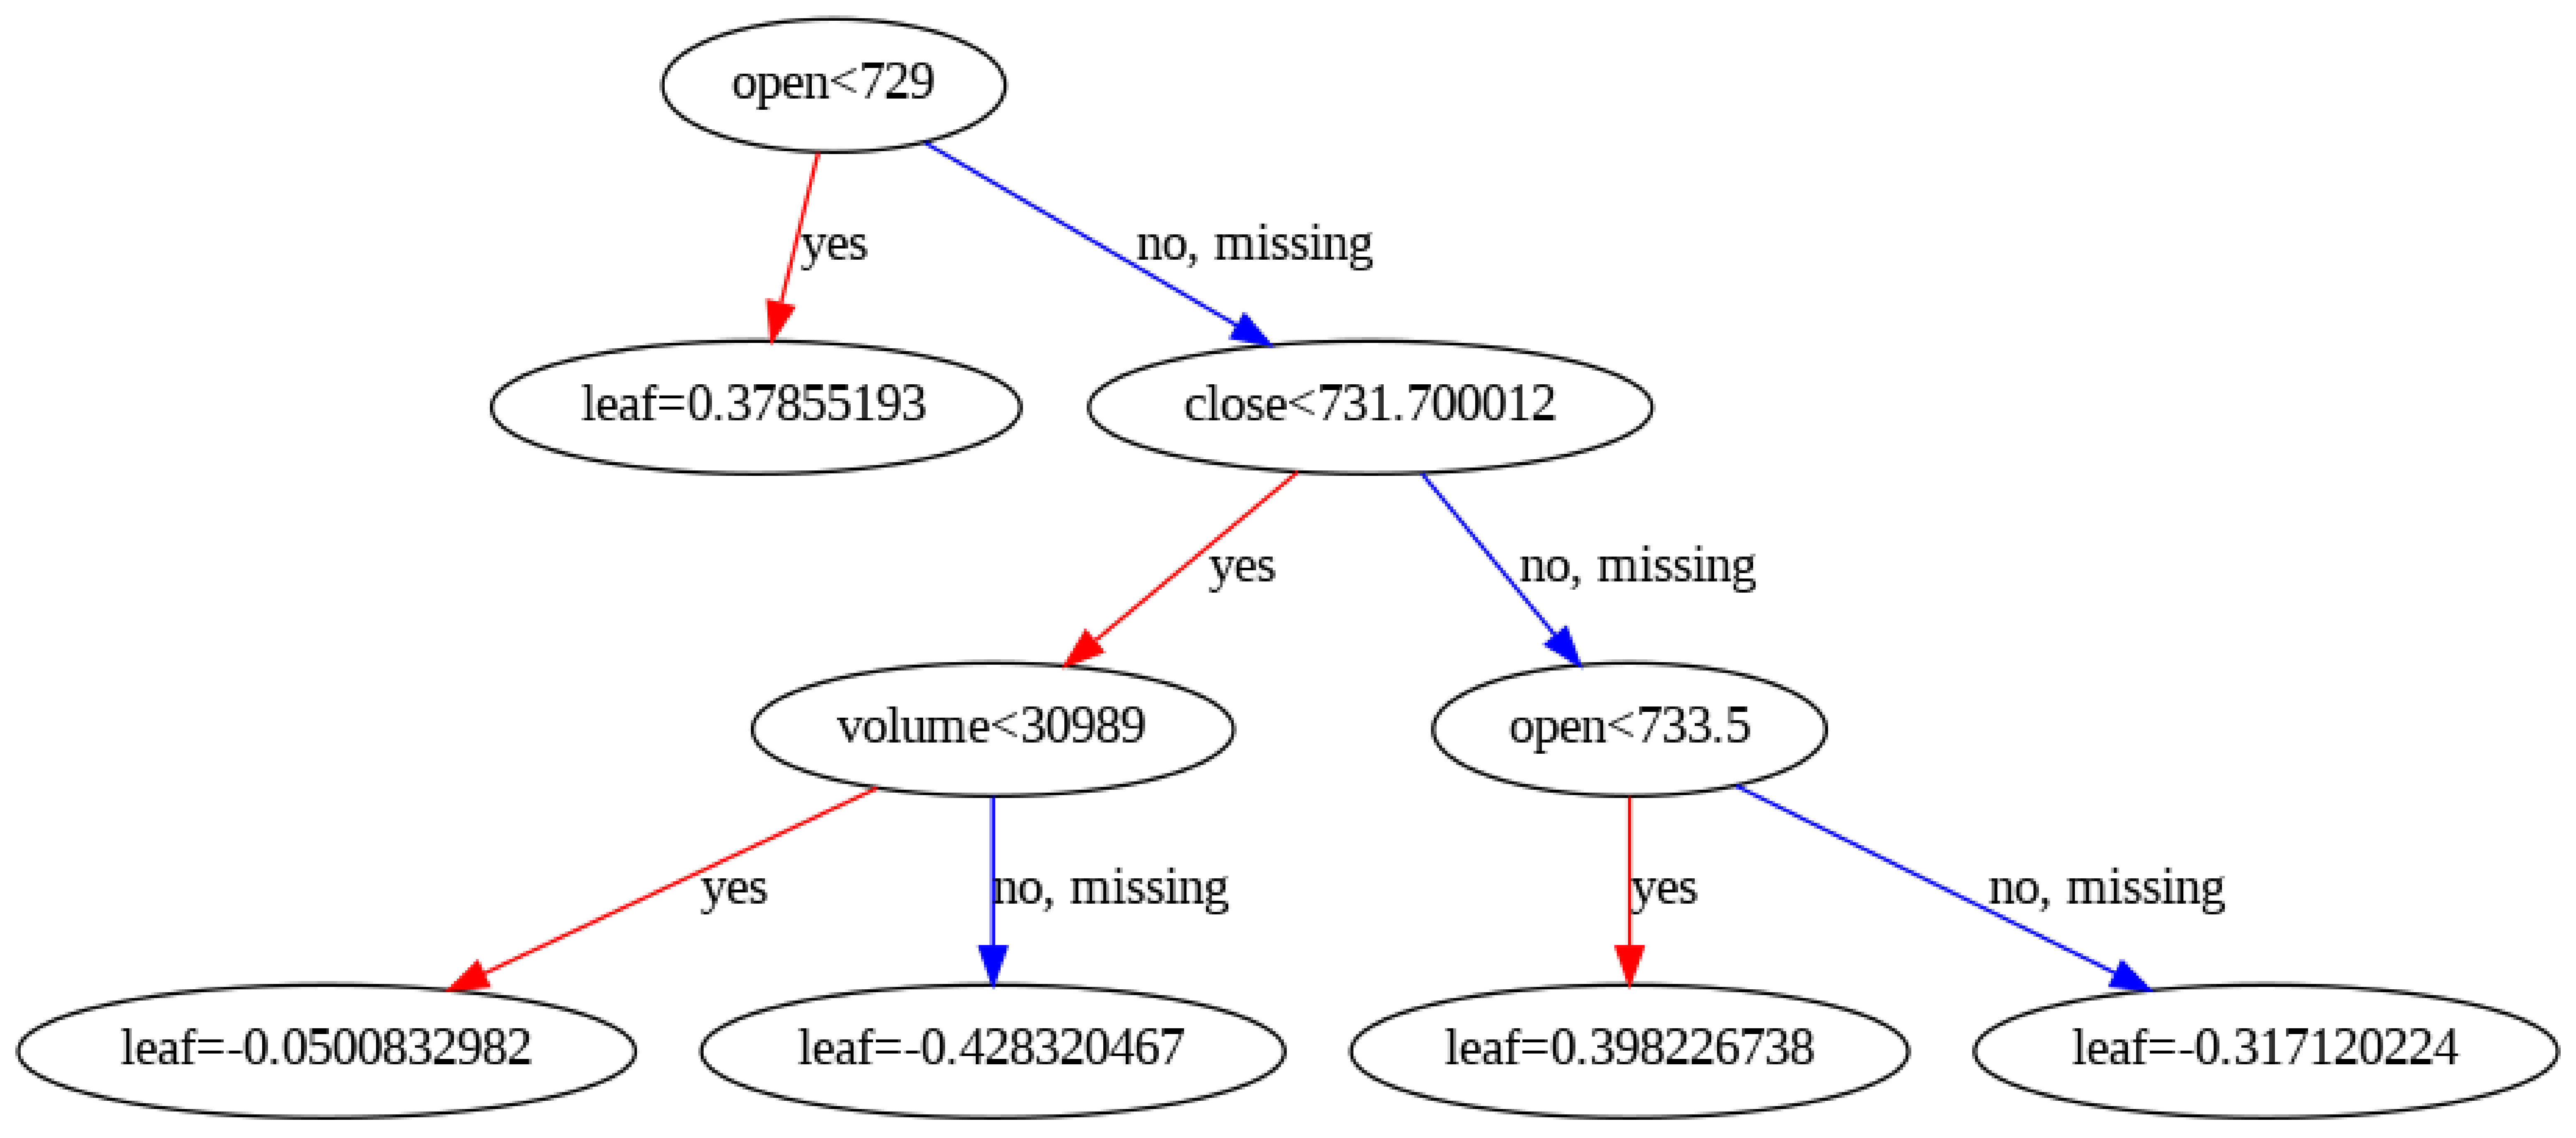

[I 250207 09:56:06 <ipython-input-11-bb3a868b3b1b>:148] 🔹 Predicted Move: SELL


In [ ]:
# =======================
# IMPORT LIBRARIES
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from matplotlib.pylab import rcParams
from SmartApi.smartConnect import SmartConnect
import time
import pyotp
from logzero import logger

# =======================
# USER CONFIGURATION
# =======================
API_KEY = "uMU5cqo6"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"

STOCK_SYMBOL = "AEGISCHEM"
EXCHANGE = "NSE"
INTERVAL = "ONE_MINUTE"

# =======================
# STEP 1: LOGIN TO SMART API
# =======================
def login_smart_api():
    try:
        obj = SmartConnect(api_key=API_KEY)
        totp = pyotp.TOTP(TOTP_SECRET).now()
        login_data = obj.generateSession(CLIENT_CODE, PASSWORD, totp)
        return obj
    except Exception as e:
        logger.error(f"Login Error: {e}")
        return None

api_obj = login_smart_api()
if api_obj:
    logger.info("✅ Successfully logged in!")

# =======================
# STEP 2: FETCH HISTORICAL DATA
# =======================
def fetch_historical_data(api_obj):
    try:
        params = {
            "exchange": EXCHANGE,
            "symboltoken": "14947",  # Token for Aegis Logistics
            "interval": INTERVAL,
            "fromdate": "2025-02-05 12:30",
            "todate": "2025-02-05 13:20",
        }
        data = api_obj.getCandleData(params)
        df = pd.DataFrame(data['data'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    except Exception as e:
        logger.error(f"Data Fetch Error: {e}")
        return None

df = fetch_historical_data(api_obj)
if df is not None:
    logger.info("✅ Successfully fetched historical data!")
    logger.info(df.head())

# =======================
# STEP 3: FIT, PREDICT, PRINT FUNCTION
# =======================
def fit_predict_print(model, X_train, X_test, y_train, y_test):
    try:
        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        logger.info(f"Model Accuracy: {accuracy:.4f}")
        logger.info("\n" + classification_report(y_test, y_pred))

        # Return trained model and predictions
        return model, y_pred
    except Exception as e:
        logger.error(f"Model Training or Prediction Error: {e}")
        return None, None

# =======================
# STEP 4: TRAIN XGBOOST MODEL
# =======================
def train_xgboost(df):
    try:
        # Calculate percentage returns and create binary signals
        df['returns'] = df['close'].pct_change()  # Percentage change in close prices
        df['signal'] = (df['returns'] > 0).astype(int)  # 1 for buy, 0 for sell
        df.dropna(inplace=True)  # Drop NaN values

        if df.empty:
            logger.error("Error: No data available for training after dropping NaN values.")
            return None

        # Define Features & Target
        X = df[['open', 'high', 'low', 'close', 'volume']]
        y = df['signal']
        y.dropna(inplace=True)
        X = X.iloc[:len(y)]  # Ensure X and y lengths match

        # Split data into training and testing sets
        X_train, X_test = X[:-10], X[-10:]
        y_train, y_test = y[:-10], y[-10:]

        # Train XGBoost Classifier
        model = XGBClassifier(seed=49, use_label_encoder=False, eval_metric='logloss')
        model, y_pred = fit_predict_print(model, X_train, X_test, y_train, y_test)

        if model:
            # Plot a tree from the XGBoost model
            rcParams['figure.figsize'] = 80, 50
            plot_tree(model, num_trees=0)  # Plot the first tree
            plt.show()

        return model
    except Exception as e:
        logger.error(f"XGBoost Training Error: {e}")
        return None

# Call the training function
xgb_model = train_xgboost(df)

# =======================
# STEP 5: PREDICT NEXT MOVE
# =======================
def predict_next_move(df, model):
    try:
        latest_data = df[['open', 'high', 'low', 'close', 'volume']].iloc[-1:]
        predicted_signal = model.predict(latest_data)[0]

        if predicted_signal == 1:
            signal = "BUY"
        else:
            signal = "SELL"

        logger.info(f"🔹 Predicted Move: {signal}")
        return signal
    except Exception as e:
        logger.error(f"Prediction Error: {e}")
        return None

# Predict the next move
if xgb_model:
    signal = predict_next_move(df, xgb_model)

[I 250207 22:47:38 smartConnect:124] in pool
[I 250207 22:47:40 <ipython-input-27-9e2834787efd>:44] ✅ Successfully logged in!
[I 250207 22:47:40 <ipython-input-27-9e2834787efd>:68] ✅ Successfully fetched historical data!
[I 250207 22:47:40 <ipython-input-27-9e2834787efd>:69]                   timestamp    open    high     low   close  volume
    0 2025-01-27 09:30:00+05:30  652.05  652.80  645.25  645.95  161263
    1 2025-01-27 09:35:00+05:30  646.30  651.00  644.25  648.85  118484
    2 2025-01-27 09:40:00+05:30  648.55  650.00  641.00  648.25  161952
    3 2025-01-27 09:45:00+05:30  648.25  654.45  644.50  645.55  174105
    4 2025-01-27 09:50:00+05:30  645.55  646.00  637.00  637.90  169969
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:47:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 250207 22:47:41 <ipython-input-27-9e2834787efd>:84] Model Accuracy: 0.7000
[I 250

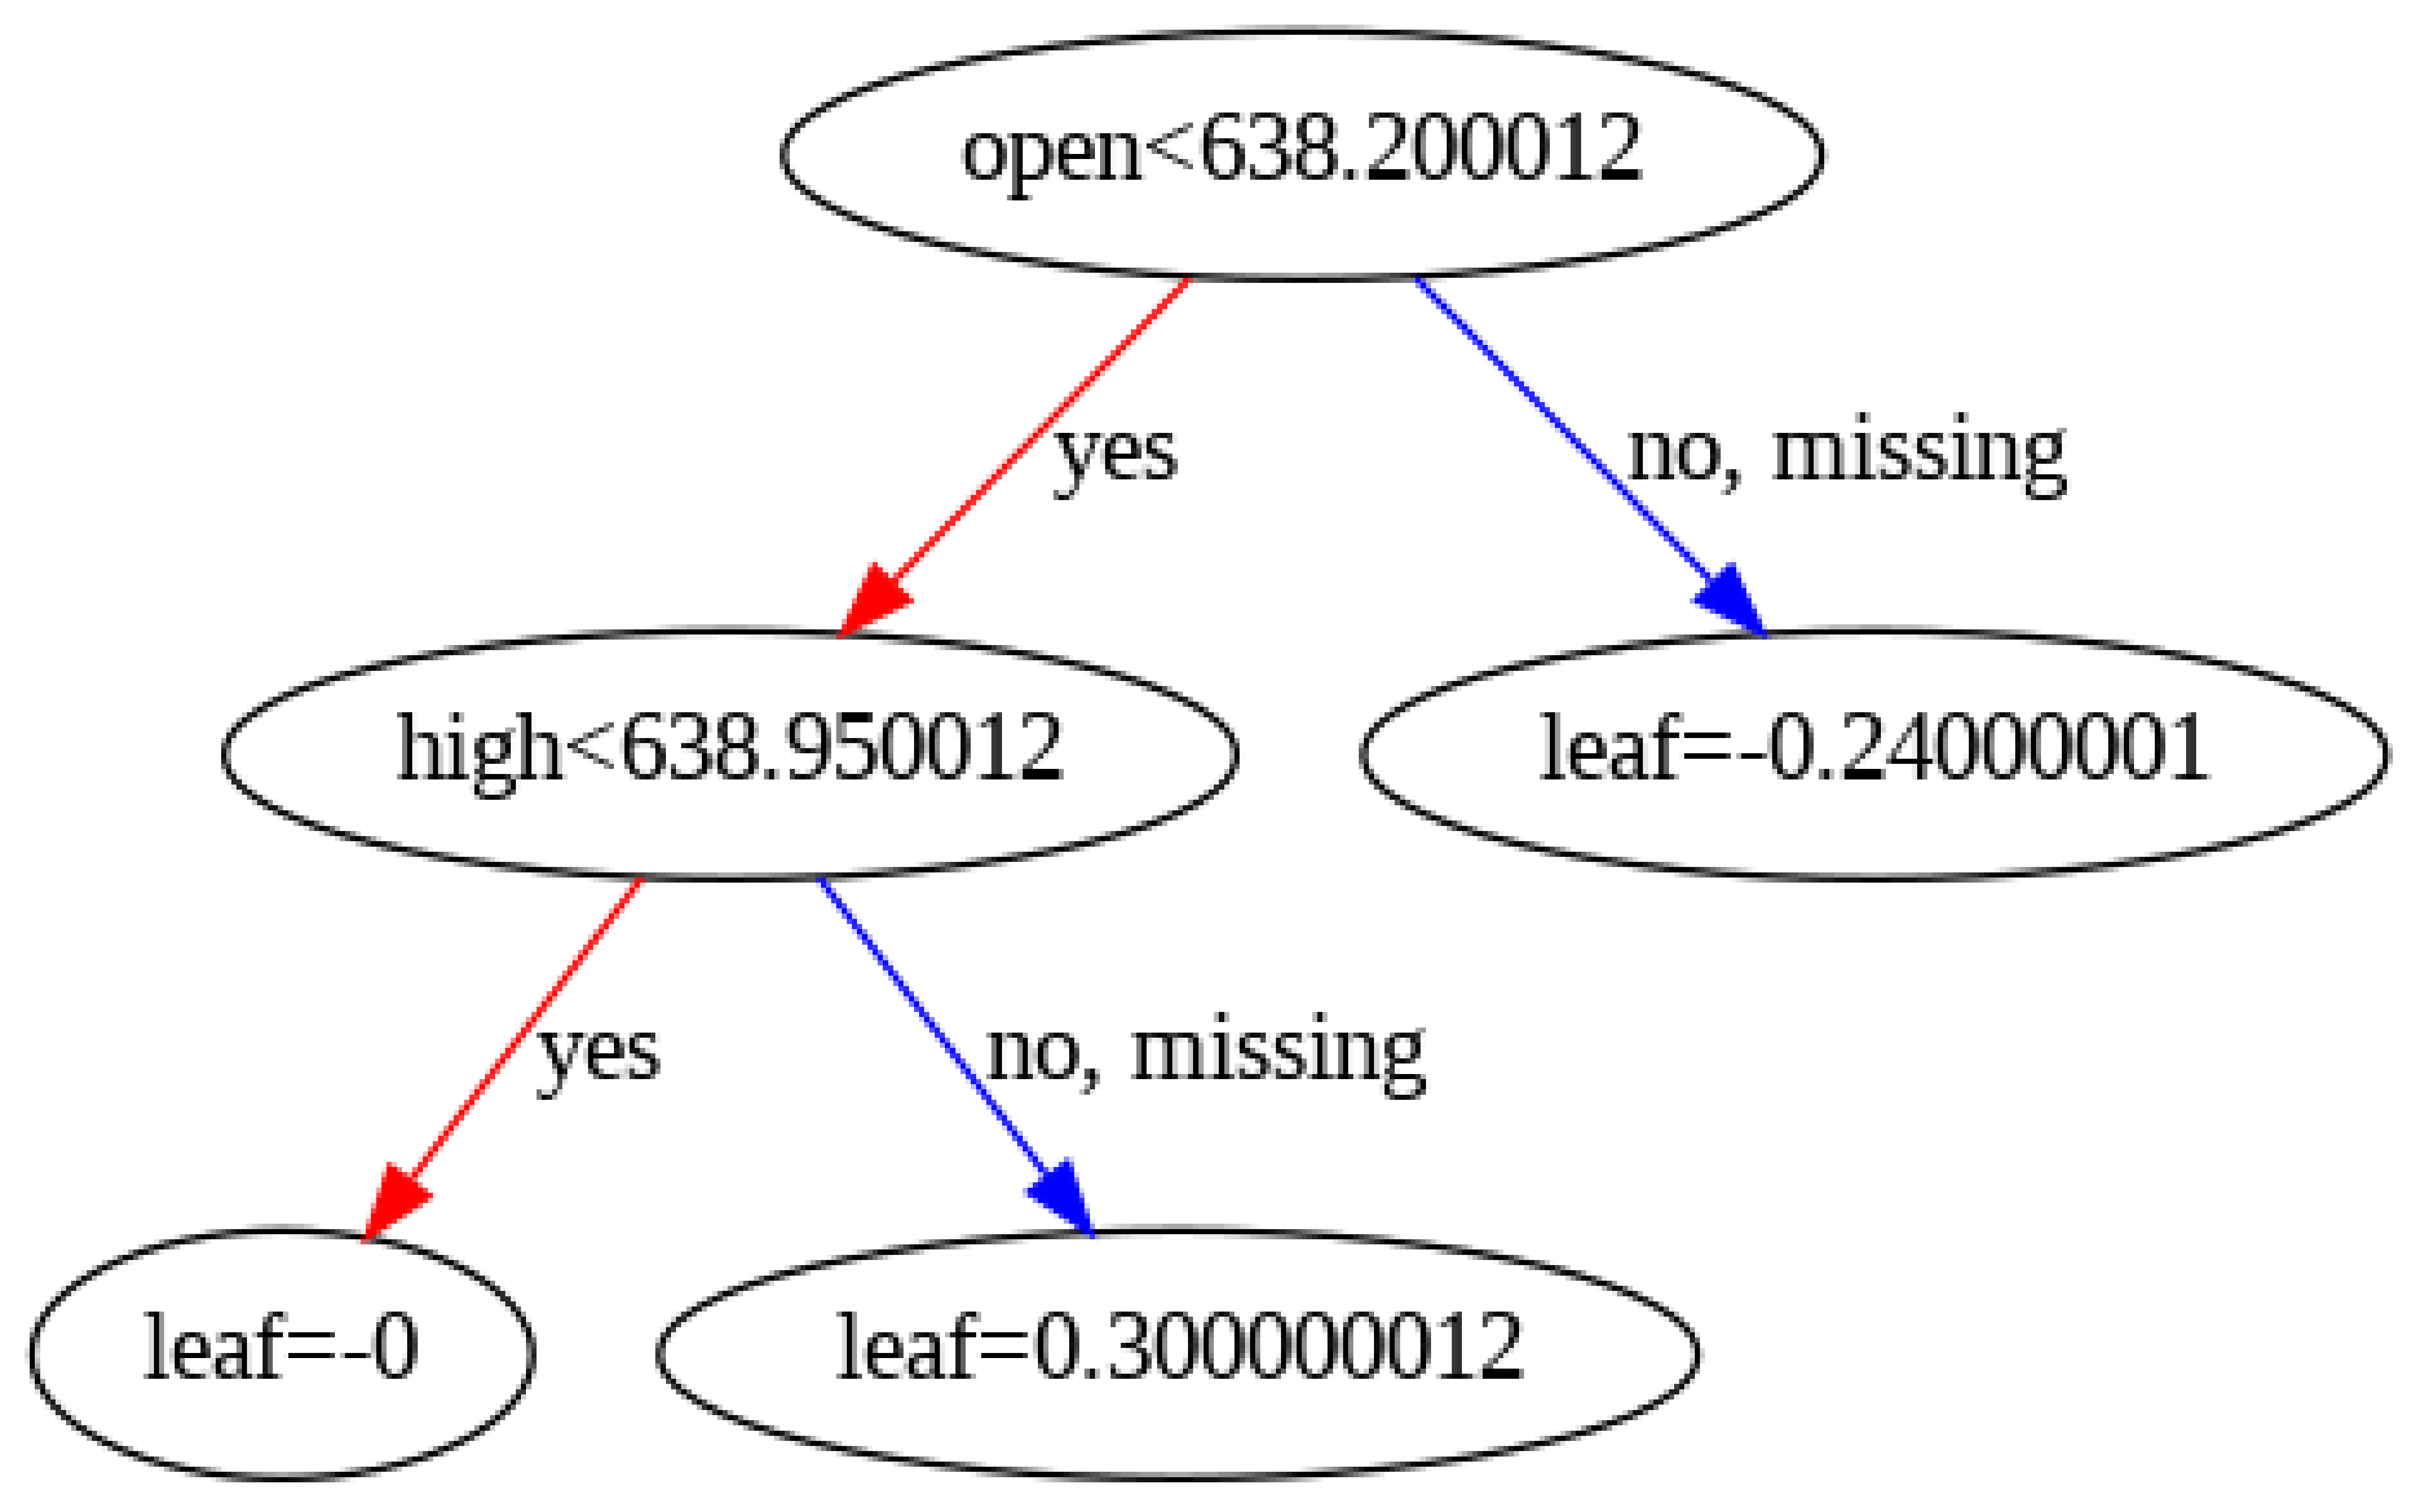

[I 250207 22:47:45 <ipython-input-27-9e2834787efd>:158] 🔹 Predicted Move: BUY
[I 250207 22:47:45 <ipython-input-27-9e2834787efd>:159] 🎯 Target Price: 653.97
[I 250207 22:47:45 <ipython-input-27-9e2834787efd>:160] ⚠️ Stop-Loss Price: 631.53


In [ ]:
# =======================
# IMPORT LIBRARIES
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from matplotlib.pylab import rcParams
from SmartApi.smartConnect import SmartConnect
import time
import pyotp
from logzero import logger

# =======================
# USER CONFIGURATION
# =======================
API_KEY = "uMU5cqo6"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"

STOCK_SYMBOL = "AEGISCHEM"
EXCHANGE = "NSE"
INTERVAL = "FIVE_MINUTE"

# =======================
# STEP 1: LOGIN TO SMART API
# =======================
def login_smart_api():
    try:
        obj = SmartConnect(api_key=API_KEY)
        totp = pyotp.TOTP(TOTP_SECRET).now()
        login_data = obj.generateSession(CLIENT_CODE, PASSWORD, totp)
        return obj
    except Exception as e:
        logger.error(f"Login Error: {e}")
        return None

api_obj = login_smart_api()
if api_obj:
    logger.info("✅ Successfully logged in!")

# =======================
# STEP 2: FETCH HISTORICAL DATA
# =======================
def fetch_historical_data(api_obj):
    try:
        params = {
            "exchange": EXCHANGE,
            "symboltoken": "14947",  # Token for Aegis Logistics
            "interval": INTERVAL,
            "fromdate": "2025-01-27 09:30",
            "todate": "2025-01-27 11:30",
        }
        data = api_obj.getCandleData(params)
        df = pd.DataFrame(data['data'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    except Exception as e:
        logger.error(f"Data Fetch Error: {e}")
        return None

df = fetch_historical_data(api_obj)
if df is not None:
    logger.info("✅ Successfully fetched historical data!")
    logger.info(df.head())

# =======================
# STEP 3: FIT, PREDICT, PRINT FUNCTION
# =======================
def fit_predict_print(model, X_train, X_test, y_train, y_test):
    try:
        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        logger.info(f"Model Accuracy: {accuracy:.4f}")
        logger.info("\n" + classification_report(y_test, y_pred))

        # Return trained model and predictions
        return model, y_pred
    except Exception as e:
        logger.error(f"Model Training or Prediction Error: {e}")
        return None, None

# =======================
# STEP 4: TRAIN XGBOOST MODEL
# =======================
def train_xgboost(df):
    try:
        # Calculate percentage returns and create binary signals
        df['returns'] = df['close'].pct_change()  # Percentage change in close prices
        df['signal'] = (df['returns'] > 0).astype(int)  # 1 for buy, 0 for sell
        df.dropna(inplace=True)  # Drop NaN values

        if df.empty:
            logger.error("Error: No data available for training after dropping NaN values.")
            return None

        # Define Features & Target
        X = df[['open', 'high', 'low', 'close', 'volume']]
        y = df['signal']
        y.dropna(inplace=True)
        X = X.iloc[:len(y)]  # Ensure X and y lengths match

        # Split data into training and testing sets
        X_train, X_test = X[:-10], X[-10:]
        y_train, y_test = y[:-10], y[-10:]

        # Train XGBoost Classifier
        model = XGBClassifier(seed=49, use_label_encoder=False, eval_metric='logloss')
        model, y_pred = fit_predict_print(model, X_train, X_test, y_train, y_test)

        if model:
            # Plot a tree from the XGBoost model
            rcParams['figure.figsize'] = 80, 50
            plot_tree(model, num_trees=0)  # Plot the first tree
            plt.show()

        return model
    except Exception as e:
        logger.error(f"XGBoost Training Error: {e}")
        return None

# Call the training function
xgb_model = train_xgboost(df)

# =======================
# STEP 5: PREDICT NEXT MOVE
# =======================
# =======================
# STEP 5: PREDICT NEXT MOVE WITH TARGET & STOP LOSS
# =======================
def predict_next_move(df, model):
    try:
        latest_data = df[['open', 'high', 'low', 'close', 'volume']].iloc[-1:]
        latest_close = latest_data['close'].values[0]  # Get the latest closing price

        # Predict signal (BUY or SELL)
        predicted_signal = model.predict(latest_data)[0]

        if predicted_signal == 1:
            signal = "BUY"
            target_price = latest_close * 1.02  # Target = +2% of current price
            stop_loss = latest_close * 0.985   # Stop Loss = -1.5% of current price
        else:
            signal = "SELL"
            target_price = latest_close * 0.98  # Target = -2% of current price
            stop_loss = latest_close * 1.015   # Stop Loss = +1.5% of current price

        logger.info(f"🔹 Predicted Move: {signal}")
        logger.info(f"🎯 Target Price: {target_price:.2f}")
        logger.info(f"⚠️ Stop-Loss Price: {stop_loss:.2f}")

        return signal, round(target_price, 2), round(stop_loss, 2)
    except Exception as e:
        logger.error(f"Prediction Error: {e}")
        return None, None, None

# Predict the next move
if xgb_model:
    signal, target_price, stop_loss = predict_next_move(df, xgb_model)



In [ ]:
# =======================
# IMPORT LIBRARIES
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from SmartApi.smartConnect import SmartConnect
import pyotp
import pickle

# =======================
# USER CONFIGURATION
# =======================
API_KEY = "uMU5cqo6"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"

STOCK_SYMBOL = "NSE:NIFTY"  # Replace with your stock symbol
EXCHANGE = "NSE"
INTERVAL = "FIVE_MINUTE"

# =======================
# STEP 1: LOGIN TO SMART API
# =======================
def login_smart_api():
    try:
        obj = SmartConnect(api_key=API_KEY)
        totp = pyotp.TOTP(TOTP_SECRET).now()
        obj.generateSession(CLIENT_CODE, PASSWORD, totp)
        return obj
    except Exception as e:
        print(f"Login Error: {e}")
        return None

api_obj = login_smart_api()
if api_obj:
    print("✅ Successfully logged in!")

# =======================
# STEP 2: FETCH HISTORICAL DATA
# =======================
def fetch_historical_data(api_obj):
    try:
        params = {
            "exchange": EXCHANGE,
            "symboltoken": "3878",
            "interval": INTERVAL,
            "fromdate": "2024-02-01 09:15",
            "todate": "2024-02-01 15:30",
        }
        data = api_obj.getCandleData(params)
        df = pd.DataFrame(data['data'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    except Exception as e:
        print(f"Data Fetch Error: {e}")
        return None

df = fetch_historical_data(api_obj)
if df is not None:
    print("✅ Successfully fetched historical data!")
    print(df.head())

# =======================
# STEP 3: TRAIN THE MODEL
# =======================
def train_model(df):
    df['returns'] = df['close'].pct_change()
    df.dropna(inplace=True)


    X = df[['open', 'high', 'low', 'close', 'volume']]
    y = df['returns'].shift(-1)
    y.dropna(inplace=True)
    X = X.iloc[:len(y)]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model, X_test, y_test

model, X_test, y_test = train_model(df)
print("✅ Model training completed!")


with open('trained_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("✅ Model saved to 'trained_model.pkl'.")

# =======================
# STEP 4: PREDICT NEXT MOVE
# =======================
def predict_next_move(df, model):
    latest_data = df[['open', 'high', 'low', 'close', 'volume']].iloc[-1:]
    predicted_return = model.predict(latest_data)[0]

    signal = "BUY" if predicted_return > 0 else "SELL"
    target_price = df['close'].iloc[-1] * (1 + predicted_return)
    stop_loss = df['close'].iloc[-1] * (1 - abs(predicted_return))

    return signal, target_price, stop_loss

signal, target_price, stop_loss = predict_next_move(df, model)
print(f"🔹 Predicted Move: {signal}")
print(f"🎯 Target Price: {target_price:.2f}")
print(f"🛑 Stop Loss: {stop_loss:.2f}")

# =======================
# STEP 5: PLACE A TRADE ORDER
# =======================
def place_trade(api_obj, signal, target_price, stop_loss):
    try:
        order_params = {
            "variety": "NORMAL",
            "tradingsymbol": STOCK_SYMBOL,
            "symboltoken": "99926000",  # Replace with your stock token
            "transactiontype": "BUY" if signal == "BUY" else "SELL",
            "exchange": EXCHANGE,
            "ordertype": "LIMIT",
            "producttype": "INTRADAY",
            "duration": "DAY",
            "price": target_price,
            "squareoff": str(abs(target_price - stop_loss)),
            "stoploss": str(abs(stop_loss - target_price)),
        }
        order_id = api_obj.placeOrder(order_params)
        print(f"✅ Order placed successfully! Order ID: {order_id}")
    except Exception as e:
        print(f"Trade Error: {e}")

place_trade(api_obj, signal, target_price, stop_loss)

# =======================
# STEP 6: PREDICT ON NEW DATA
# =======================
def predict_on_new_data(model, new_data_path='new_data.csv'):
    # Load new data
    new_data = pd.read_csv(new_data_path)

    # Ensure new data has the required features
    new_data = new_data[['open', 'high', 'low', 'close', 'volume']]

    # Predict returns
    predictions = model.predict(new_data)

    # Add predictions to the dataframe
    new_data['predicted_returns'] = predictions

    new_data.to_csv('predictions.csv', index=False)
    print("✅ Predictions saved to 'predictions.csv'.")

predict_on_new_data(model, new_data_path='new_data.csv')


ModuleNotFoundError: No module named 'SmartApi'

In [ ]:
# =======================
# IMPORT LIBRARIES
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from SmartApi.smartConnect import SmartConnect
import time
import pyotp

# =======================
# USER CONFIGURATION
# =======================
API_KEY = "uMU5cqo6"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"

STOCK_SYMBOL = "WIPRO"  # Replace with your stock symbol
EXCHANGE = "NSE"
INTERVAL = "FIVE_MINUTE"
DURATION = "120"

# =======================
# STEP 1: LOGIN TO ANGEL ONE
# =======================
def login_smart_api():
    try:
        obj = SmartConnect(api_key=API_KEY)
        totp = pyotp.TOTP(TOTP_SECRET).now()
        login_data = obj.generateSession(CLIENT_CODE, PASSWORD, totp)
        return obj
    except Exception as e:
        print(f"Login Error: {e}")
        return None

api_obj = login_smart_api()
if api_obj:
    print("✅ Successfully logged in!")

# =======================
# STEP 2: FETCH HISTORICAL DATA
# =======================
def fetch_historical_data(api_obj):
    try:
        params = {
            "exchange": EXCHANGE,
            "symboltoken": "3787",
            "interval": INTERVAL,
            "fromdate": "2024-02-01 09:30",
            "todate": "2024-02-01 11:30",
        }
        data = api_obj.getCandleData(params)
        df = pd.DataFrame(data['data'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    except Exception as e:
        print(f"Data Fetch Error: {e}")
        return None

df = fetch_historical_data(api_obj)
if df is not None:
    print("✅ Successfully fetched historical data!")
    print(df.head())

# =======================
# STEP 3: TRAIN ML MODEL
# =======================
def train_model(df):
    df['returns'] = df['close'].pct_change()
    df.dropna(inplace=True)

    # Define Features & Target
    X = df[['open', 'high', 'low', 'close', 'volume']]
    y = df['returns'].shift(-1)

    # Split data
    X_train, X_test = X[:-10], X[-10:]
    y_train, y_test = y[:-10], y[-10:]

    # Train Model
    model = RandomForestRegressor(n_estimators=100)
    model.fit(X_train, y_train)
    return model

model = train_model(df)
print("✅ Model training completed!")

# =======================
# STEP 4: PREDICT NEXT MOVE
# =======================
def predict_next_move(df, model):
    latest_data = df[['open', 'high', 'low', 'close', 'volume']].iloc[-1:]
    predicted_return = model.predict(latest_data)[0]

    if predicted_return > 0:
        signal = "BUY"
    else:
        signal = "SELL"

    target_price = df['close'].iloc[-1] * (1 + predicted_return)
    stop_loss = df['close'].iloc[-1] * (1 - predicted_return)

    return signal, target_price, stop_loss

signal, target_price, stop_loss = predict_next_move(df, model)
print(f"🔹 Predicted Move: {signal}")
print(f"🎯 Target Price: {target_price:.2f}")
print(f"🛑 Stop Loss: {stop_loss:.2f}")

# =======================
# STEP 5: PLACE TRADE ORDER
# =======================
def place_trade(api_obj, signal, target_price, stop_loss):
    try:
        order_params = {
            "variety": "NORMAL",
            "tradingsymbol": STOCK_SYMBOL,
            "symboltoken": "99926000",  # NIFTY 50 Token
            "transactiontype": "BUY" if signal == "BUY" else "SELL",
            "exchange": EXCHANGE,
            "ordertype": "LIMIT",
            "producttype": "INTRADAY",
            "duration": "DAY",
            "price": target_price,
            "squareoff": str(abs(target_price - stop_loss)),
            "stoploss": str(abs(stop_loss - target_price)),
        }
        order_id = api_obj.placeOrder(order_params)
        print(f"✅ Order Placed Successfully! Order ID: {order_id}")
    except Exception as e:
        print(f"Trade Error: {e}")

place_trade(api_obj, signal, target_price, stop_loss)

[I 250207 22:48:12 smartConnect:124] in pool


✅ Successfully logged in!
✅ Successfully fetched historical data!
                  timestamp    open    high     low   close  volume
0 2024-02-01 09:30:00+05:30  236.03  237.18  236.00  236.83  211016
1 2024-02-01 09:35:00+05:30  236.88  236.95  236.50  236.60  130030
2 2024-02-01 09:40:00+05:30  236.55  237.68  236.50  237.53  226674
3 2024-02-01 09:45:00+05:30  237.58  237.98  237.45  237.63  250970
4 2024-02-01 09:50:00+05:30  237.53  238.03  237.50  237.75  111644
✅ Model training completed!
🔹 Predicted Move: BUY
🎯 Target Price: 236.96
🛑 Stop Loss: 236.00


[E 250207 22:48:16 smartConnect:246] Error occurred while making a POST request to https://apiconnect.angelone.in/rest/secure/angelbroking/order/v1/placeOrder. Error: Entered trading symbol and symbol token is mismatch. URL: https://apiconnect.angelone.in/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '02:42:ac:1c:00:0c', 'Accept': 'application/json', 'X-PrivateKey': 'uMU5cqo6', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'WIPRO', 'symboltoken': '99926000', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 236.96283143406967, 'squareoff': '0.9656628681393613', 'stoploss': '0.9656628681393613'}, Response: {'message': 'Entered trading symbol and symbol token is mismatch', 'errorcode': 'AB1019', 'status': False, 'data': None}
[E 250207 22:48:

✅ Order Placed Successfully! Order ID: None


In [ ]:
# =======================
# IMPORT LIBRARIES
# =======================
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger

# =======================
# USER CONFIGURATION
# =======================
API_KEY = "uMU5cqo6"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"

STOCK_SYMBOL = "AEGISCHEM"
EXCHANGE = "NSE"
INTERVAL = "FIVE_MINUTE"

# =======================
# STEP 1: LOGIN TO SMART API
# =======================
def login_smart_api():
    try:
        obj = SmartConnect(api_key=API_KEY)
        totp = pyotp.TOTP(TOTP_SECRET).now()
        obj.generateSession(CLIENT_CODE, PASSWORD, totp)
        logger.info("✅ Successfully logged in!")
        return obj
    except Exception as e:
        logger.error(f"Login Error: {e}")
        return None

api_obj = login_smart_api()

# =======================
# STEP 2: FETCH HISTORICAL DATA
# =======================
def fetch_historical_data(api_obj):
    try:
        params = {
            "exchange": EXCHANGE,
            "symboltoken": "3787",  # Token for Aegis Logistics
            "interval": INTERVAL,
            "fromdate": "2025-01-27 09:30",
            "todate": "2025-01-27 11:30",
        }
        data = api_obj.getCandleData(params)
        df = pd.DataFrame(data['data'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    except Exception as e:
        logger.error(f"Data Fetch Error: {e}")
        return None

df = fetch_historical_data(api_obj)
if df is not None:
    logger.info("✅ Successfully fetched historical data!")
    logger.info(df.head())

# =======================
# STEP 3: TRAIN ML MODEL
# =======================
def train_model(df):
    try:
        df['returns'] = df['close'].pct_change()  # Calculate percentage change
        df.dropna(inplace=True)  # Drop NaN values

        if df.empty:
            logger.error("Error: No data available for training after dropping NaN values.")
            return None

        # Define Features & Target
        X = df[['open', 'high', 'low', 'close', 'volume']]
        y = df['returns'].shift(-1)  # Predict next period return
        y.dropna(inplace=True)  # Drop NaN in target
        X = X.iloc[:len(y)]  # Ensure X and y lengths match

        # Split data
        X_train, X_test = X[:-10], X[-10:]
        y_train, y_test = y[:-10], y[-10:]

        # Train Model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        # Evaluate Model
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        logger.info(f"Model RMSE: {rmse:.4f}")

        return model
    except Exception as e:
        logger.error(f"Model Training Error: {e}")
        return None

model = train_model(df)
if model:
    logger.info("✅ Model training completed!")

# =======================
# STEP 4: PREDICT NEXT MOVE
# =======================
def predict_next_move(df, model):
    try:
        latest_data = df[['open', 'high', 'low', 'close', 'volume']].iloc[-1:]
        predicted_return = model.predict(latest_data)[0]

        # Define BUY or SELL signal
        if predicted_return > 0:
            signal = "BUY"
        else:
            signal = "SELL"

        # Calculate target price and stop-loss dynamically
        market_price = df['close'].iloc[-1]
        target_price = market_price * (1 + abs(predicted_return))
        stop_loss = market_price * (1 - abs(predicted_return))

        logger.info(f"🔹 Predicted Move: {signal}")
        logger.info(f"🎯 Target Price: {target_price:.2f}")
        logger.info(f"🛑 Stop Loss: {stop_loss:.2f}")

        return signal, target_price, stop_loss
    except Exception as e:
        logger.error(f"Prediction Error: {e}")
        return None, None, None

if model:
    signal, target_price, stop_loss = predict_next_move(df, model)


[I 250204 18:32:08 smartConnect:124] in pool
[I 250204 18:32:09 <ipython-input-44-017bb3d16f49>:32] ✅ Successfully logged in!
[I 250204 18:32:10 <ipython-input-44-017bb3d16f49>:62] ✅ Successfully fetched historical data!
[I 250204 18:32:10 <ipython-input-44-017bb3d16f49>:63]                   timestamp    open    high     low   close  volume
    0 2025-01-27 09:30:00+05:30  317.60  318.45  317.25  317.40  244108
    1 2025-01-27 09:35:00+05:30  317.40  318.30  317.05  317.45  256403
    2 2025-01-27 09:40:00+05:30  317.30  317.45  316.25  316.45  183137
    3 2025-01-27 09:45:00+05:30  316.45  316.45  315.65  315.75  209602
    4 2025-01-27 09:50:00+05:30  315.85  316.45  315.45  315.85  174946
[I 250204 18:32:10 <ipython-input-44-017bb3d16f49>:94] Model RMSE: 0.0018
[I 250204 18:32:10 <ipython-input-44-017bb3d16f49>:103] ✅ Model training completed!
[I 250204 18:32:10 <ipython-input-44-017bb3d16f49>:124] 🔹 Predicted Move: SELL
[I 250204 18:32:10 <ipython-input-44-017bb3d16f49>:125] 🎯 T

In [ ]:
# =======================
# IMPORT LIBRARIES
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from SmartApi.smartConnect import SmartConnect
import pyotp
import time
from logzero import logger

# =======================
# USER CONFIGURATION
# =======================
API_KEY = "uMU5cqo6"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"

STOCK_SYMBOL = "NIFTY"
EXCHANGE = "NSE"
INTERVAL = "FIVE_MINUTE"

# =======================
# STEP 1: LOGIN TO SMART API
# =======================
def login_smart_api():
    try:
        obj = SmartConnect(api_key=API_KEY)
        totp = pyotp.TOTP(TOTP_SECRET).now()
        obj.generateSession(CLIENT_CODE, PASSWORD, totp)
        return obj
    except Exception as e:
        logger.error(f"Login Error: {e}")
        return None

api_obj = login_smart_api()
if api_obj:
    logger.info("✅ Successfully logged in!")

# =======================
# STEP 2: FETCH HISTORICAL DATA
# =======================
def fetch_historical_data(api_obj, stock_token):
    try:
        params = {
            "exchange": EXCHANGE,
            "symboltoken": stock_token,
            "interval": INTERVAL,
            "fromdate": "2025-02-07 09:00",
            "todate": "2025-02-07 11:00",
        }
        data = api_obj.getCandleData(params)

        if not data or 'data' not in data or not data['data']:
            logger.error(f"No data fetched for stock token: {stock_token}")
            return None

        df = pd.DataFrame(data['data'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    except Exception as e:
        logger.error(f"Data Fetch Error for {stock_token}: {e}")
        return None

stock_token = "13637"  # Example token for NIFTY (Update with actual token)
df = fetch_historical_data(api_obj, stock_token)
if df is None or df.empty:
    raise Exception("No historical data fetched. Please check the stock symbol or API configuration.")

logger.info("✅ Successfully fetched historical data!")

# =======================
# STEP 3: FEATURE ENGINEERING FOR STRATEGIES
# =======================
def apply_trading_strategies(df):
    # Calculate moving averages
    df['SMA_5'] = df['close'].rolling(window=5).mean()
    df['SMA_10'] = df['close'].rolling(window=10).mean()

    # Momentum Strategy
    df['momentum'] = df['close'] - df['close'].shift(5)

    # Gap and Go Strategy
    df['gap'] = df['open'] - df['close'].shift(1)
    df['gap_signal'] = np.where(df['gap'] > df['gap'].rolling(5).mean(), 1, 0)

    # Bull Flag Strategy (Checking upward trends)
    df['bull_flag'] = np.where((df['close'] > df['SMA_5']) & (df['SMA_5'] > df['SMA_10']), 1, 0)

    # Breakout Strategy
    df['high_10'] = df['high'].rolling(10).max()
    df['breakout'] = np.where(df['close'] > df['high_10'].shift(1), 1, 0)

    # Scalping (Checking small rapid price movements)
    df['scalp_signal'] = np.where(df['close'].diff() > 0, 1, 0)

    df.dropna(inplace=True)
    return df

df = apply_trading_strategies(df)

# =======================
# STEP 4: TRAIN RANDOM FOREST MODEL
# =======================
def train_model(df):
    X = df[['momentum', 'gap_signal', 'bull_flag', 'breakout', 'scalp_signal']]
    y = np.where(df['close'].shift(-1) > df['close'], 1, 0)  # 1 for buy, 0 for sell

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logger.info(f"✅ Model Accuracy: {accuracy:.4f}")
    logger.info("\n" + classification_report(y_test, y_pred))

    return model

model = train_model(df)

# =======================
# STEP 5: PREDICT NEXT MOVE
# =======================
def predict_next_move(df, model):
    latest_data = df[['momentum', 'gap_signal', 'bull_flag', 'breakout', 'scalp_signal']].iloc[-1:]
    predicted_signal = model.predict(latest_data)[0]

    latest_close = df['close'].iloc[-1]

    if predicted_signal == 1:
        signal = "BUY"
        target_price = latest_close * 1.02  # 2% target
        stop_loss = latest_close * 0.98    # 2% stop loss
    else:
        signal = "SELL"
        target_price = latest_close * 0.98  # 2% target
        stop_loss = latest_close * 1.02    # 2% stop loss

    logger.info(f"🔹 Predicted Move: {signal}")
    logger.info(f"🎯 Target Price: {target_price:.2f}")
    logger.info(f"🛑 Stop Loss: {stop_loss:.2f}")

    return signal, round(target_price, 2), round(stop_loss, 2)

signal, target_price, stop_loss = predict_next_move(df, model)


[I 250207 05:32:05 smartConnect:124] in pool
[I 250207 05:32:07 <ipython-input-9-304efe5e2d7c>:42] ✅ Successfully logged in!
[I 250207 05:32:08 <ipython-input-9-304efe5e2d7c>:74] ✅ Successfully fetched historical data!
[I 250207 05:32:08 <ipython-input-9-304efe5e2d7c>:120] ✅ Model Accuracy: 0.6667
[I 250207 05:32:08 <ipython-input-9-304efe5e2d7c>:121] 
                  precision    recall  f1-score   support
    
               0       1.00      0.50      0.67         2
               1       0.50      1.00      0.67         1
    
        accuracy                           0.67         3
       macro avg       0.75      0.75      0.67         3
    weighted avg       0.83      0.67      0.67         3
    
[I 250207 05:32:08 <ipython-input-9-304efe5e2d7c>:145] 🔹 Predicted Move: SELL
[I 250207 05:32:08 <ipython-input-9-304efe5e2d7c>:146] 🎯 Target Price: 113.88
[I 250207 05:32:08 <ipython-input-9-304efe5e2d7c>:147] 🛑 Stop Loss: 118.52


In [ ]:
# =======================
# IMPORT LIBRARIES
# =======================
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from SmartApi.smartConnect import SmartConnect
import pyotp
import time
from logzero import logger

# =======================
# USER CONFIGURATION
# =======================
API_KEY = "tNb8azqi"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"

STOCK_SYMBOL = "NIFTY"
EXCHANGE = "NSE"
INTERVAL = "FIVE_MINUTE"

# =======================
# STEP 1: LOGIN TO SMART API
# =======================
def login_smart_api():
    obj = SmartConnect(api_key=API_KEY)
    totp = pyotp.TOTP(TOTP_SECRET).now()
    obj.generateSession(CLIENT_CODE, PASSWORD, totp)
    return obj

api_obj = login_smart_api()
stock_token = "13637"

# =======================
# STEP 2: FETCH HISTORICAL DATA
# =======================
def fetch_historical_data(api_obj, stock_token):
    params = {
        "exchange": EXCHANGE,
        "symboltoken": stock_token,
        "interval": INTERVAL,
        "fromdate": "2025-02-07 09:00",
        "todate": "2025-02-07 11:00",
    }
    data = api_obj.getCandleData(params)
    df = pd.DataFrame(data['data'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

df = fetch_historical_data(api_obj, stock_token)

# =======================
# STEP 3: FEATURE ENGINEERING
# =======================
def apply_trading_strategies(df):
    df['SMA_5'] = df['close'].rolling(window=5).mean()
    df['SMA_10'] = df['close'].rolling(window=10).mean()
    df['momentum'] = df['close'] - df['close'].shift(5)
    df['breakout'] = np.where(df['close'] > df['high'].rolling(10).max().shift(1), 1, 0)
    df['sma_crossover'] = np.where(df['SMA_5'] > df['SMA_10'], 1, 0)
    df.dropna(inplace=True)
    return df

df = apply_trading_strategies(df)

# =======================
# STEP 4: TRAIN XGBOOST MODEL
# =======================
def train_xgboost(df):
    X = df[['momentum', 'breakout', 'sma_crossover']]
    y = np.where(df['close'].shift(-1) > df['close'], 1, 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logger.info(f"✅ XGBoost Model Accuracy: {accuracy:.4f}")
    logger.info("\n" + classification_report(y_test, y_pred))

    return model

model = train_xgboost(df)

# =======================
# STEP 5: PREDICT NEXT MOVE
# =======================
def predict_next_move(df, model):
    latest_data = df[['momentum', 'breakout', 'sma_crossover']].iloc[-1:]
    predicted_signal = model.predict(latest_data)[0]

    latest_close = df['close'].iloc[-1]
    if predicted_signal == 1:
        signal = "BUY"
        target_price = latest_close * 1.02
        stop_loss = latest_close * 0.98
    else:
        signal = "SELL"
        target_price = latest_close * 0.98
        stop_loss = latest_close * 1.02

    logger.info(f"🔹 Predicted Move: {signal}")
    logger.info(f"🎯 Target Price: {target_price:.2f}")
    logger.info(f"🛑 Stop Loss: {stop_loss:.2f}")

    return signal, round(target_price, 2), round(stop_loss, 2)

signal, target_price, stop_loss = predict_next_move(df, model)


[I 250207 22:27:55 smartConnect:124] in pool
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:27:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 250207 22:27:58 <ipython-input-23-f4d1f50a47ef>:83] ✅ XGBoost Model Accuracy: 1.0000
[I 250207 22:27:58 <ipython-input-23-f4d1f50a47ef>:84] 
                  precision    recall  f1-score   support
    
               0       1.00      1.00      1.00         2
               1       1.00      1.00      1.00         1
    
        accuracy                           1.00         3
       macro avg       1.00      1.00      1.00         3
    weighted avg       1.00      1.00      1.00         3
    
[I 250207 22:27:58 <ipython-input-23-f4d1f50a47ef>:107] 🔹 Predicted Move: SELL
[I 250207 22:27:58 <ipython-input-23-f4d1f50a47ef>:108] 🎯 Target Price: 114.29
[I 250207 22:27:58 <ipython-input-23-f4d1f50a47ef>:109] 🛑 Stop Loss: 118.95


FInal Report

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from matplotlib.pylab import rcParams
from SmartApi.smartConnect import SmartConnect
import time
import pyotp
from logzero import logger

# User Configuration
API_KEY = "uMU5cqo6"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"
EXCHANGE = "NSE"
INTERVAL = "FIVE_MINUTE"

# Extracted stock codes
stock_list = [
    "14947", "11626", "19800", "11253", "4235", "11580", "3766", "18011", "3772", "24969",
    "3787", "7506", "3002", "22277", "14828", "3799", "11705", "8477", "11407", "11915",
    "3812", "20852", "14003", "4176", "1076", "7508", "13391", "3821", "3824", "11394",
    "29050", "3827", "17635"
]

# Login to Smart API
def login_smart_api():
    try:
        obj = SmartConnect(api_key=API_KEY)
        totp = pyotp.TOTP(TOTP_SECRET).now()
        obj.generateSession(CLIENT_CODE, PASSWORD, totp)
        return obj
    except Exception as e:
        logger.error(f"Login Error: {e}")
        return None

api_obj = login_smart_api()

# Fetch historical data
def fetch_historical_data(api_obj, stock_token):
    try:
        params = {
            "exchange": EXCHANGE,
            "symboltoken": stock_token,
            "interval": INTERVAL,
            "fromdate": "2025-02-05 09:30",
            "todate": "2025-02-05 14:00",
        }
        data = api_obj.getCandleData(params)
        df = pd.DataFrame(data['data'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    except Exception as e:
        logger.error(f"Data Fetch Error for {stock_token}: {e}")
        return None

# Train and predict
def train_xgboost(df):
    try:
        df['returns'] = df['close'].pct_change()
        df['signal'] = (df['returns'] > 0).astype(int)
        df.dropna(inplace=True)

        if df.empty:
            return None

        X = df[['open', 'high', 'low', 'close', 'volume']]
        y = df['signal']
        X_train, X_test = X[:-10], X[-10:]
        y_train, y_test = y[:-10], y[-10:]

        model = XGBClassifier(seed=49, use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train, y_train)
        return model
    except Exception as e:
        logger.error(f"Training Error: {e}")
        return None

# Predict next move
def predict_next_move(df, model):
    try:
        latest_data = df[['open', 'high', 'low', 'close', 'volume']].iloc[-1:]
        latest_close = latest_data['close'].values[0]
        predicted_signal = model.predict(latest_data)[0]

        if predicted_signal == 1:
            return "BUY", round(latest_close * 1.02, 2), round(latest_close * 0.985, 2)
        else:
            return "SELL", round(latest_close * 0.98, 2), round(latest_close * 1.015, 2)
    except Exception as e:
        logger.error(f"Prediction Error: {e}")
        return None, None, None

# Run for all stocks
if api_obj:
    results = []
    for stock_token in stock_list:
        df = fetch_historical_data(api_obj, stock_token)
        if df is not None:
            model = train_xgboost(df)
            if model:
                signal, target, stop_loss = predict_next_move(df, model)
                results.append((stock_token, signal, target, stop_loss))

    # Print results
    print("Stock Predictions:")
    for stock, signal, target, stop_loss in results:
        print(f"Stock: {stock} | Signal: {signal} | Target: {target} | Stop Loss: {stop_loss}")


[I 250207 22:46:46 smartConnect:124] in pool
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:46:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:46:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:46:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:46:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:46:52] WARNING: /workspace/sr

Stock Predictions:
Stock: 14947 | Signal: BUY | Target: 736.54 | Stop Loss: 711.27
Stock: 11626 | Signal: BUY | Target: 589.25 | Stop Loss: 569.03
Stock: 19800 | Signal: SELL | Target: 889.25 | Stop Loss: 921.01
Stock: 11253 | Signal: SELL | Target: 128.73 | Stop Loss: 133.33
Stock: 4235 | Signal: SELL | Target: 11584.24 | Stop Loss: 11997.96
Stock: 11580 | Signal: BUY | Target: 876.69 | Stop Loss: 846.61
Stock: 3766 | Signal: BUY | Target: 711.96 | Stop Loss: 687.53
Stock: 18011 | Signal: SELL | Target: 1105.78 | Stop Loss: 1145.28
Stock: 3772 | Signal: SELL | Target: 35.06 | Stop Loss: 36.32
Stock: 24969 | Signal: SELL | Target: 313.6 | Stop Loss: 324.8
Stock: 3787 | Signal: BUY | Target: 323.08 | Stop Loss: 312.0
Stock: 7506 | Signal: BUY | Target: 1688.05 | Stop Loss: 1630.13
Stock: 3002 | Signal: BUY | Target: 730.17 | Stop Loss: 705.11
Stock: 22277 | Signal: BUY | Target: 173.74 | Stop Loss: 167.78
Stock: 14828 | Signal: SELL | Target: 97.75 | Stop Loss: 101.24
Stock: 3799 | Sign

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:47:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from matplotlib.pylab import rcParams
from SmartApi.smartConnect import SmartConnect
import time
import pyotp
from logzero import logger

# ==============================
# 🔹 USER CONFIGURATION
# ==============================
API_KEY = "uMU5cqo6"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"
EXCHANGE = "NSE"
INTERVAL = "FIVE_MINUTE"

# 🔹 Extracted stock tokens (Top 33 stocks)
stock_list = [
    "11256", "11626", "19800", "11253", "4235", "11580", "3766", "18011", "3772", "24969"
]

# ==============================
# 🔹 LOGIN TO SMART API
# ==============================
def login_smart_api():
    try:
        obj = SmartConnect(api_key=API_KEY)
        totp = pyotp.TOTP(TOTP_SECRET).now()
        obj.generateSession(CLIENT_CODE, PASSWORD, totp)
        return obj
    except Exception as e:
        logger.error(f"Login Error: {e}")
        return None

api_obj = login_smart_api()

# ==============================
# 🔹 FETCH HISTORICAL DATA
# ==============================
def fetch_historical_data(api_obj, stock_token, start_time, end_time):
    try:
        params = {
            "exchange": EXCHANGE,
            "symboltoken": stock_token,
            "interval": INTERVAL,
            "fromdate": start_time,
            "todate": end_time,
        }
        data = api_obj.getCandleData(params)
        df = pd.DataFrame(data['data'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    except Exception as e:
        logger.error(f"Data Fetch Error for {stock_token}: {e}")
        return None

# ==============================
# 🔹 FEATURE ENGINEERING (CUSTOMIZE FOR EACH STRATEGY)
# ==============================
def feature_engineering(df):
    """
    Add your strategy-specific feature engineering here.
    Example: Calculate RSI, MACD, Bollinger Bands, etc.
    """
    # Example: Calculate RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df.dropna(inplace=True)
    return df

# ==============================
# 🔹 TRAIN MODEL (CUSTOMIZE FOR EACH STRATEGY)
# ==============================
def train_model(df):
    """
    Add your strategy-specific model training here.
    Example: Logistic Regression, SVM, LSTM, etc.
    """
    try:
        # Example: Train Logistic Regression
        from sklearn.linear_model import LogisticRegression

        X = df[['RSI']]  # Use strategy-specific features
        y = np.where(df['close'].shift(-1) > df['close'], 1, 0)  # Target variable
        X_train, X_test = X[:-10], X[-10:]
        y_train, y_test = y[:-10], y[-10:]

        model = LogisticRegression(random_state=42)
        model.fit(X_train, y_train)
        return model
    except Exception as e:
        logger.error(f"Training Error: {e}")
        return None

# ==============================
# 🔹 PREDICT NEXT MOVE (CUSTOMIZE FOR EACH STRATEGY)
# ==============================
def predict_next_move(df, model):
    """
    Add your strategy-specific prediction logic here.
    """
    try:
        latest_data = df[['RSI']].iloc[-1:]
        latest_close = df['close'].iloc[-1]
        predicted_signal = model.predict(latest_data)[0]

        if predicted_signal == 1:
            return "BUY", round(latest_close * 1.02, 2), round(latest_close * 0.99, 2)
        else:
            return "SELL", round(latest_close * 0.99, 2), round(latest_close * 1.01, 2)
    except Exception as e:
        logger.error(f"Prediction Error: {e}")
        return None, None, None

# ==============================
# 🔹 VALIDATE PREDICTION (CHECK BETWEEN 11 AM AND 3:15 PM)
# ==============================
def validate_prediction(df, signal, target_price, stop_loss):
    """
    Check if the target price or stop loss is hit at any point between 11 AM and 3:15 PM.
    Return the result and the timestamp when the event occurred.
    """
    try:
        # Filter data between 11 AM and 3:15 PM
        df_validation = df[(df['timestamp'].dt.time >= pd.to_datetime('11:30').time()) &
                           (df['timestamp'].dt.time <= pd.to_datetime('15:15').time())]

        if df_validation.empty:
            return "⚠️ No Data for Validation", None

        # Check if target or stop loss is hit
        if signal == "BUY":
            target_hit = df_validation[df_validation['high'] >= target_price]
            stop_loss_hit = df_validation[df_validation['low'] <= stop_loss]

            if not target_hit.empty:
                return "✅ Target Hit", target_hit.iloc[0]['timestamp']
            elif not stop_loss_hit.empty:
                return "❌ Stop Loss Hit", stop_loss_hit.iloc[0]['timestamp']
            else:
                return "🔹 No Clear Outcome", None
        else:  # SELL
            target_hit = df_validation[df_validation['low'] <= target_price]
            stop_loss_hit = df_validation[df_validation['high'] >= stop_loss]

            if not target_hit.empty:
                return "✅ Target Hit", target_hit.iloc[0]['timestamp']
            elif not stop_loss_hit.empty:
                return "❌ Stop Loss Hit", stop_loss_hit.iloc[0]['timestamp']
            else:
                return "🔹 No Clear Outcome", None
    except Exception as e:
        logger.error(f"Validation Error: {e}")
        return "⚠️ Error", None

# ==============================
# 🔹 EXECUTE PREDICTIONS & VALIDATIONS
# ==============================
if api_obj:
    results = []

    for stock_token in stock_list:
        logger.info(f"📊 Processing Stock Token: {stock_token}")

        # 🔹 Fetch data from 9:30 AM - 12:30 PM
        df_train = fetch_historical_data(api_obj, stock_token, "2025-02-06 09:30", "2025-02-06 12:30")
        if df_train is not None:
            df_train = feature_engineering(df_train)  # Apply feature engineering
            model = train_model(df_train)  # Train the model
            if model:
                # 🔹 Predict for 12:30 PM - 2:30 PM
                df_test = fetch_historical_data(api_obj, stock_token, "2025-02-06 12:30", "2025-02-06 14:30")
                if df_test is not None:
                    df_test = feature_engineering(df_test)  # Apply feature engineering
                    signal, target_price, stop_loss = predict_next_move(df_test, model)

                    # 🔹 Fetch data for validation (11 AM - 3:15 PM)
                    df_validation = fetch_historical_data(api_obj, stock_token, "2025-02-06 11:00", "2025-02-06 15:15")
                    if df_validation is not None:
                        result, event_time = validate_prediction(df_validation, signal, target_price, stop_loss)
                    else:
                        result, event_time = "⚠️ No Data for Validation", None

                    results.append((stock_token, signal, target_price, stop_loss, result, event_time))

    # ==============================
    # 🔹 PRINT FULL REPORT
    # ==============================
    print("\n📊 Final Report:")
    print("="*80)
    print(f"{'Stock':<10} | {'Signal':<5} | {'Target':<8} | {'Stop Loss':<8} | {'Result':<15} | {'Event Time':<20}")
    print("="*80)
    for stock, signal, target, stop_loss, result, event_time in results:
        event_time_str = str(event_time) if event_time else "None"
        print(f"{stock:<10} | {signal:<5} | {target:<8} | {stop_loss:<8} | {result:<15} | {event_time_str:<20}")
    print("="*80)

[I 250207 22:56:34 smartConnect:124] in pool
[I 250207 22:56:35 <ipython-input-37-46e7eba5de1b>:173] 📊 Processing Stock Token: 11256
[I 250207 22:56:37 <ipython-input-37-46e7eba5de1b>:173] 📊 Processing Stock Token: 11626
[I 250207 22:56:40 <ipython-input-37-46e7eba5de1b>:173] 📊 Processing Stock Token: 19800
[E 250207 22:56:41 <ipython-input-37-46e7eba5de1b>:102] Training Error: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LogisticRegression.
[I 250207 22:56:41 <ipython-input-37-46e7eba5de1b>:173] 📊 Processing Stock Token: 11253
[I 250207 22:56:43 <ipython-input-37-46e7eba5de1b>:173] 📊 Processing Stock Token: 4235
[I 250207 22:56:45 <ipython-input-37-46e7eba5de1b>:173] 📊 Processing Stock Token: 11580
[I 250207 22:56:47 <ipython-input-37-46e7eba5de1b>:173] 📊 Processing Stock Token: 3766
[E 250207 22:56:48 <ipython-input-37-46e7eba5de1b>:102] Training Error: This solver needs samples of at least 2 classes in the data, but the data contains only one class


📊 Final Report:
Stock      | Signal | Target   | Stop Loss | Result          | Event Time          
11256      | SELL  | 145.15   | 148.09   | ✅ Target Hit    | 2025-02-06 12:15:00+05:30
11626      | SELL  | 574.5    | 586.1    | ✅ Target Hit    | 2025-02-06 11:30:00+05:30
11253      | SELL  | 128.39   | 130.99   | ❌ Stop Loss Hit | 2025-02-06 11:30:00+05:30
4235       | SELL  | 11615.27 | 11849.93 | ❌ Stop Loss Hit | 2025-02-06 11:45:00+05:30
11580      | BUY   | 875.57   | 849.82   | ✅ Target Hit    | 2025-02-06 15:05:00+05:30
18011      | BUY   | 1132.46  | 1099.15  | 🔹 No Clear Outcome | None                
24969      | BUY   | 331.3    | 321.55   | ❌ Stop Loss Hit | 2025-02-06 12:10:00+05:30


Fetching Top gainers of the day using smart api

In [5]:
import pandas as pd
import numpy as np
import time
import pyotp
from logzero import logger
from SmartApi.smartConnect import SmartConnect
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report

# =======================
# 🔹 USER CONFIGURATION
# =======================
API_KEY = "uMU5cqo6"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"
EXCHANGE = "NSE"
INTERVAL = "FIVE_MINUTE"

stock_list = ["11256", "11626", "19800", "11253", "4235",
             "11580", "3766", "18011", "3772", "24969"]

# =======================
# 🔹 HELPER FUNCTIONS
# =======================
def login_smart_api():
    try:
        obj = SmartConnect(api_key=API_KEY)
        totp = pyotp.TOTP(TOTP_SECRET).now()
        obj.generateSession(CLIENT_CODE, PASSWORD, totp)
        return obj
    except Exception as e:
        logger.error(f"Login Error: {e}")
        return None

def fetch_historical_data(api_obj, stock_token, from_date, to_date):
    try:
        params = {
            "exchange": EXCHANGE,
            "symboltoken": stock_token,
            "interval": INTERVAL,
            "fromdate": from_date,
            "todate": to_date,
        }
        data = api_obj.getCandleData(params)
        df = pd.DataFrame(data['data'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    except Exception as e:
        logger.error(f"Data Fetch Error: {e}")
        return None

def validate_prediction(validation_df, signal, target_price, stop_loss):
    try:
        if signal == "BUY":
            target_hit = validation_df[validation_df['high'] >= target_price]
            stop_hit = validation_df[validation_df['low'] <= stop_loss]
        else:
            target_hit = validation_df[validation_df['low'] <= target_price]
            stop_hit = validation_df[validation_df['high'] >= stop_loss]

        if not target_hit.empty:
            return "Target Hit", target_hit.iloc[0]['timestamp']
        elif not stop_hit.empty:
            return "Stop Loss Hit", stop_hit.iloc[0]['timestamp']
        else:
            return "No Outcome", None
    except Exception as e:
        logger.error(f"Validation Error: {e}")
        return "Error", None

# =======================
# 🔹 MODEL DEFINITIONS
# =======================
def model1_logistic_rsi(train_df):
    """Logistic Regression with RSI"""
    try:
        # Feature Engineering
        delta = train_df['close'].diff()
        gain = delta.where(delta > 0, 0).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        train_df['RSI'] = 100 - (100 / (1 + (gain/loss)))
        train_df.dropna(inplace=True)

        if len(train_df) < 15: return None  # Insufficient data

        # Prepare data
        X = train_df[['RSI']][:-1]
        y = np.where(train_df['close'].shift(-1) > train_df['close'], 1, 0)[:-1]

        # Train model
        model = LogisticRegression()
        model.fit(X, y)
        return model
    except Exception as e:
        logger.error(f"Model 1 Training Error: {e}")
        return None

def model2_xgboost_basic(train_df):
    """XGBoost with OHLCV Features"""
    try:
        train_df['target'] = (train_df['close'].pct_change().shift(-1) > 0).astype(int)
        train_df.dropna(inplace=True)

        if len(train_df) < 10: return None

        X = train_df[['open', 'high', 'low', 'close', 'volume']][:-1]
        y = train_df['target'][:-1]

        model = XGBClassifier()
        model.fit(X, y)
        return model
    except Exception as e:
        logger.error(f"Model 2 Training Error: {e}")
        return None

def model3_xgboost_advanced(train_df):
    """XGBoost with Technical Indicators"""
    try:
        # Feature Engineering
        train_df['SMA_5'] = train_df['close'].rolling(5).mean()
        train_df['SMA_10'] = train_df['close'].rolling(10).mean()
        train_df['momentum'] = train_df['close'] - train_df['close'].shift(5)
        train_df['breakout'] = (train_df['close'] > train_df['high'].rolling(10).max().shift(1)).astype(int)
        train_df.dropna(inplace=True)

        if len(train_df) < 15: return None

        X = train_df[['momentum', 'breakout', 'SMA_5', 'SMA_10']][:-1]
        y = np.where(train_df['close'].shift(-1) > train_df['close'], 1, 0)[:-1]

        model = XGBClassifier()
        model.fit(X, y)
        return model
    except Exception as e:
        logger.error(f"Model 3 Training Error: {e}")
        return None

# =======================
# 🔹 PREDICTION FUNCTIONS
# =======================
def predict_model1(model, train_df):
    try:
        # Calculate latest RSI
        delta = train_df['close'].diff()
        gain = delta.where(delta > 0, 0).rolling(14).mean().iloc[-1]
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean().iloc[-1]
        rsi = 100 - (100 / (1 + (gain/loss)))

        prediction = model.predict([[rsi]])[0]
        close_price = train_df['close'].iloc[-1]

        if prediction == 1:
            return "BUY", round(close_price*1.02, 2), round(close_price*0.98, 2)
        else:
            return "SELL", round(close_price*0.98, 2), round(close_price*1.02, 2)
    except Exception as e:
        logger.error(f"Model1 Prediction Error: {e}")
        return None, None, None

def predict_model2(model, train_df):
    try:
        latest_data = train_df[['open', 'high', 'low', 'close', 'volume']].iloc[-1]
        prediction = model.predict([latest_data])[0]
        close_price = latest_data['close']

        if prediction == 1:
            return "BUY", round(close_price*1.015, 2), round(close_price*0.985, 2)
        else:
            return "SELL", round(close_price*0.985, 2), round(close_price*1.015, 2)
    except Exception as e:
        logger.error(f"Model2 Prediction Error: {e}")
        return None, None, None

# =======================
# 🔹 MAIN EXECUTION
# =======================
if __name__ == "__main__":
    api_obj = login_smart_api()
    if not api_obj:
        exit("Failed to login to API")

    # Define models to compare
    models = [
        {
            'name': 'Logistic Regression (RSI)',
            'train_func': model1_logistic_rsi,
            'predict_func': predict_model1
        },
        {
            'name': 'XGBoost (Basic)',
            'train_func': model2_xgboost_basic,
            'predict_func': predict_model2
        },
        # Add other models here following the same pattern
    ]

    results = []

    for stock_token in stock_list:
        logger.info(f"Processing {stock_token}...")

        # Fetch training data (9:30 AM - 12:30 PM)
        train_df = fetch_historical_data(api_obj, stock_token,
                                       "2025-02-06 09:30", "2025-02-06 12:30")

        # Fetch validation data (12:30 PM - 3:15 PM)
        validation_df = fetch_historical_data(api_obj, stock_token,
                                            "2025-02-06 12:30", "2025-02-06 15:15")

        if train_df is None or validation_df is None:
            continue

        for model in models:
            try:
                # Train model
                ml_model = model['train_func'](train_df)
                if not ml_model:
                    continue

                # Make prediction
                signal, target, stop_loss = model['predict_func'](ml_model, train_df)
                if not signal:
                    continue

                # Validate prediction
                result, event_time = validate_prediction(validation_df,
                                                        signal, target, stop_loss)

                # Store results
                results.append({
                    'Stock': stock_token,
                    'Model': model['name'],
                    'Signal': signal,
                    'Target': target,
                    'Stop Loss': stop_loss,
                    'Result': result,
                    'Event Time': event_time
                })

            except Exception as e:
                logger.error(f"Error processing {model['name']}: {e}")

    # Generate Report
    report_df = pd.DataFrame(results)

    # Calculate performance metrics
    performance = []
    for model_name in report_df['Model'].unique():
        model_data = report_df[report_df['Model'] == model_name]
        total = len(model_data)
        hits = sum(model_data['Result'] == 'Target Hit')
        stops = sum(model_data['Result'] == 'Stop Loss Hit')
        accuracy = hits / total if total > 0 else 0

        performance.append({
            'Model': model_name,
            'Total Predictions': total,
            'Target Hits': hits,
            'Stop Loss Hits': stops,
            'Accuracy (%)': round(accuracy*100, 2)
        })

    # Print Final Report
    print("\n=== MODEL PERFORMANCE COMPARISON ===")
    print(pd.DataFrame(performance).to_string(index=False))
    print("\n=== DETAILED RESULTS ===")
    print(report_df.to_string(index=False))

[I 250210 11:06:47 smartConnect:124] in pool
[I 250210 11:06:49 <ipython-input-5-3641b2dcc87e>:203] Processing 11256...
[I 250210 11:06:50 <ipython-input-5-3641b2dcc87e>:203] Processing 11626...
[I 250210 11:06:53 <ipython-input-5-3641b2dcc87e>:203] Processing 19800...
[I 250210 11:06:54 <ipython-input-5-3641b2dcc87e>:203] Processing 11253...
[I 250210 11:06:56 <ipython-input-5-3641b2dcc87e>:203] Processing 4235...
[I 250210 11:06:57 <ipython-input-5-3641b2dcc87e>:203] Processing 11580...
[I 250210 11:06:59 <ipython-input-5-3641b2dcc87e>:203] Processing 3766...
[I 250210 11:07:01 <ipython-input-5-3641b2dcc87e>:203] Processing 18011...
[I 250210 11:07:02 <ipython-input-5-3641b2dcc87e>:203] Processing 3772...
[I 250210 11:07:04 <ipython-input-5-3641b2dcc87e>:203] Processing 24969...



=== MODEL PERFORMANCE COMPARISON ===
                    Model  Total Predictions  Target Hits  Stop Loss Hits  Accuracy (%)
Logistic Regression (RSI)                  6            0               2           0.0
          XGBoost (Basic)                  8            2               2          25.0

=== DETAILED RESULTS ===
Stock                     Model Signal   Target  Stop Loss        Result                Event Time
11256 Logistic Regression (RSI)   SELL   142.09     147.89 Stop Loss Hit 2025-02-06 14:00:00+05:30
11256           XGBoost (Basic)   SELL   142.82     147.16 Stop Loss Hit 2025-02-06 14:00:00+05:30
11626 Logistic Regression (RSI)   SELL   565.95     589.05    No Outcome                       NaT
11626           XGBoost (Basic)   SELL   568.84     586.16    No Outcome                       NaT
11253 Logistic Regression (RSI)   SELL   127.76     132.98    No Outcome                       NaT
11253           XGBoost (Basic)   SELL   128.41     132.33    No Outcome      

In [8]:
import pandas as pd
import numpy as np
import time
import pyotp
from logzero import logger
from SmartApi.smartConnect import SmartConnect
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tabulate import tabulate

# =======================
# 🔹 USER CONFIGURATION
# =======================
API_KEY = "uMU5cqo6"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"
EXCHANGE = "NSE"
INTERVAL = "FIVE_MINUTE"

# Top 5 stocks for analysis
STOCKS_TO_ANALYZE = ["11256", "11626", "11253", "11580", "24969"]

# =======================
# 🔹 HELPER FUNCTIONS
# =======================
def login_smart_api():
    """Login to the Smart API."""
    try:
        obj = SmartConnect(api_key=API_KEY)
        totp = pyotp.TOTP(TOTP_SECRET).now()
        obj.generateSession(CLIENT_CODE, PASSWORD, totp)
        return obj
    except Exception as e:
        logger.error(f"Login Error: {e}")
        return None

def fetch_historical_data(api_obj, stock_token, from_date, to_date):
    """Fetch historical data for a stock."""
    try:
        params = {
            "exchange": EXCHANGE,
            "symboltoken": stock_token,
            "interval": INTERVAL,
            "fromdate": from_date,
            "todate": to_date,
        }
        data = api_obj.getCandleData(params)
        df = pd.DataFrame(data['data'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    except Exception as e:
        logger.error(f"Data Fetch Error: {e}")
        return None

def validate_prediction(validation_df, signal, target_price, stop_loss):
    """Validate if target or stop loss was hit."""
    try:
        if signal == "BUY":
            target_hit = validation_df[validation_df['high'] >= target_price]
            stop_hit = validation_df[validation_df['low'] <= stop_loss]
        else:
            target_hit = validation_df[validation_df['low'] <= target_price]
            stop_hit = validation_df[validation_df['high'] >= stop_loss]

        if not target_hit.empty:
            return "Target Hit", target_hit.iloc[0]['timestamp']
        elif not stop_hit.empty:
            return "Stop Loss Hit", stop_hit.iloc[0]['timestamp']
        else:
            return "No Outcome", None
    except Exception as e:
        logger.error(f"Validation Error: {e}")
        return "Error", None

# =======================
# 🔹 MODEL DEFINITIONS
# =======================
def model1_logistic_rsi(train_df):
    """Logistic Regression with RSI."""
    try:
        # Feature Engineering
        delta = train_df['close'].diff()
        gain = delta.where(delta > 0, 0).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        train_df['RSI'] = 100 - (100 / (1 + (gain / loss)))
        train_df.dropna(inplace=True)

        if len(train_df) < 15:
            return None  # Insufficient data

        # Prepare data
        X = train_df[['RSI']][:-1]
        y = np.where(train_df['close'].shift(-1) > train_df['close'], 1, 0)[:-1]

        # Train model
        model = LogisticRegression()
        model.fit(X, y)
        return model
    except Exception as e:
        logger.error(f"Model 1 Training Error: {e}")
        return None

def model2_xgb_basic(train_df):
    """XGBoost with OHLCV features."""
    try:
        train_df['target'] = (train_df['close'].pct_change().shift(-1) > 0).astype(int)
        train_df.dropna(inplace=True)

        if len(train_df) < 10:
            return None

        X = train_df[['open', 'high', 'low', 'close', 'volume']][:-1]
        y = train_df['target'][:-1]

        model = XGBClassifier()
        model.fit(X, y)
        return model
    except Exception as e:
        logger.error(f"Model 2 Training Error: {e}")
        return None

def model3_xgb_advanced(train_df):
    """XGBoost with advanced features."""
    try:
        # Feature Engineering
        train_df['SMA_5'] = train_df['close'].rolling(5).mean()
        train_df['SMA_10'] = train_df['close'].rolling(10).mean()
        train_df['momentum'] = train_df['close'] - train_df['close'].shift(5)
        train_df['breakout'] = (train_df['close'] > train_df['high'].rolling(10).max().shift(1)).astype(int)
        train_df.dropna(inplace=True)

        if len(train_df) < 15:
            return None

        X = train_df[['momentum', 'breakout', 'SMA_5', 'SMA_10']][:-1]
        y = np.where(train_df['close'].shift(-1) > train_df['close'], 1, 0)[:-1]

        model = XGBClassifier()
        model.fit(X, y)
        return model
    except Exception as e:
        logger.error(f"Model 3 Training Error: {e}")
        return None

def model4_random_forest(train_df):
    """Random Forest with multiple indicators."""
    try:
        train_df['SMA_5'] = train_df['close'].rolling(5).mean()
        train_df['SMA_10'] = train_df['close'].rolling(10).mean()
        train_df['momentum'] = train_df['close'] - train_df['close'].shift(5)
        train_df.dropna(inplace=True)

        if len(train_df) < 15:
            return None

        X = train_df[['SMA_5', 'SMA_10', 'momentum']][:-1]
        y = np.where(train_df['close'].shift(-1) > train_df['close'], 1, 0)[:-1]

        model = RandomForestClassifier()
        model.fit(X, y)
        return model
    except Exception as e:
        logger.error(f"Model 4 Training Error: {e}")
        return None

def model5_svm(train_df):
    """SVM with technical patterns."""
    try:
        train_df['SMA_5'] = train_df['close'].rolling(5).mean()
        train_df['SMA_10'] = train_df['close'].rolling(10).mean()
        train_df['momentum'] = train_df['close'] - train_df['close'].shift(5)
        train_df.dropna(inplace=True)

        if len(train_df) < 15:
            return None

        X = train_df[['SMA_5', 'SMA_10', 'momentum']][:-1]
        y = np.where(train_df['close'].shift(-1) > train_df['close'], 1, 0)[:-1]

        model = SVC()
        model.fit(X, y)
        return model
    except Exception as e:
        logger.error(f"Model 5 Training Error: {e}")
        return None

# =======================
# 🔹 PREDICTION FUNCTIONS
# =======================
def predict_model1(model, train_df):
    """Predict using Logistic Regression (RSI)."""
    try:
        latest_data = train_df[['RSI']].iloc[-1:]
        prediction = model.predict(latest_data)[0]
        close_price = train_df['close'].iloc[-1]

        if prediction == 1:
            return "BUY", round(close_price * 1.01, 2), round(close_price * 0.98, 2)
        else:
            return "SELL", round(close_price * 0.99, 2), round(close_price * 1.02, 2)
    except Exception as e:
        logger.error(f"Model1 Prediction Error: {e}")
        return None, None, None

def predict_model2(model, train_df):
    """Predict using XGBoost (Basic)."""
    try:
        latest_data = train_df[['open', 'high', 'low', 'close', 'volume']].iloc[-1:]
        prediction = model.predict(latest_data)[0]
        close_price = latest_data['close'].values[0]

        if prediction == 1:
            return "BUY", round(close_price * 1.015, 2), round(close_price * 0.985, 2)
        else:
            return "SELL", round(close_price * 0.985, 2), round(close_price * 1.015, 2)
    except Exception as e:
        logger.error(f"Model2 Prediction Error: {e}")
        return None, None, None

# =======================
# 🔹 MAIN EXECUTION
# =======================
if __name__ == "__main__":
    api_obj = login_smart_api()
    if not api_obj:
        exit("Failed to login to API")

    # Define models to compare
    MODELS = [
        {
            'name': 'Logistic Regression (RSI)',
            'train': model1_logistic_rsi,
            'predict': predict_model1
        },
        {
            'name': 'XGBoost (Basic)',
            'train': model2_xgb_basic,
            'predict': predict_model2
        },
        {
            'name': 'XGBoost (Advanced)',
            'train': model3_xgb_advanced,
            'predict': predict_model2
        },
        {
            'name': 'Random Forest',
            'train': model4_random_forest,
            'predict': predict_model2
        },
        {
            'name': 'SVM',
            'train': model5_svm,
            'predict': predict_model2
        }
    ]

    results = []

    for stock in STOCKS_TO_ANALYZE:
        logger.info(f"Analyzing {stock}...")

        # Fetch training and validation data
        train_df = fetch_historical_data(api_obj, stock, "2025-02-06 09:30", "2025-02-06 12:30")
        valid_df = fetch_historical_data(api_obj, stock, "2025-02-06 12:30", "2025-02-06 15:15")

        if train_df is None or valid_df is None:
            continue

        for model in MODELS:
            try:
                # Train model
                trained_model = model['train'](train_df)
                if not trained_model:
                    continue

                # Predict and validate
                signal, target, sl = model['predict'](trained_model, train_df)
                result, event_time = validate_prediction(valid_df, signal, target, sl)

                # Store results
                results.append({
                    'Stock': stock,
                    'Model': model['name'],
                    'Signal': signal,
                    'Target': target,
                    'Stop Loss': sl,
                    'Result': result,
                    'Event Time': event_time
                })

            except Exception as e:
                logger.error(f"{model['name']} failed: {str(e)}")

    # Generate report
    results_df = pd.DataFrame(results)
    print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))

[I 250210 11:55:22 smartConnect:124] in pool
[I 250210 11:55:23 <ipython-input-8-dd20a62916e9>:264] Analyzing 11256...
[E 250210 11:55:25 <ipython-input-8-dd20a62916e9>:221] Model2 Prediction Error: feature_names mismatch: ['momentum', 'breakout', 'SMA_5', 'SMA_10'] ['open', 'high', 'low', 'close', 'volume']
    expected SMA_5, momentum, breakout, SMA_10 in input data
    training data did not have the following fields: high, low, close, volume, open
[I 250210 11:55:25 <ipython-input-8-dd20a62916e9>:264] Analyzing 11626...
[E 250210 11:55:26 <ipython-input-8-dd20a62916e9>:221] Model2 Prediction Error: feature_names mismatch: ['momentum', 'breakout', 'SMA_5', 'SMA_10'] ['open', 'high', 'low', 'close', 'volume']
    expected SMA_5, momentum, breakout, SMA_10 in input data
    training data did not have the following fields: high, low, close, volume, open
[I 250210 11:55:26 <ipython-input-8-dd20a62916e9>:264] Analyzing 11253...
[E 250210 11:55:29 <ipython-input-8-dd20a62916e9>:221] Model2

+-------+---------------------------+--------+--------+-----------+---------------+---------------------------+
| Stock |           Model           | Signal | Target | Stop Loss |    Result     |        Event Time         |
+-------+---------------------------+--------+--------+-----------+---------------+---------------------------+
| 11256 | Logistic Regression (RSI) |  SELL  | 143.54 |  147.89   | Stop Loss Hit | 2025-02-06 14:00:00+05:30 |
| 11256 |      XGBoost (Basic)      |  SELL  | 142.82 |  147.16   | Stop Loss Hit | 2025-02-06 14:00:00+05:30 |
| 11256 |    XGBoost (Advanced)     |        |  nan   |    nan    |  No Outcome   |            NaT            |
| 11626 | Logistic Regression (RSI) |  SELL  | 571.72 |  589.05   |  No Outcome   |            NaT            |
| 11626 |      XGBoost (Basic)      |  SELL  | 568.84 |  586.16   |  No Outcome   |            NaT            |
| 11626 |    XGBoost (Advanced)     |        |  nan   |    nan    |  No Outcome   |            NaT      

In [21]:
import pandas as pd
import numpy as np
import time
import pyotp
from logzero import logger
from SmartApi.smartConnect import SmartConnect
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tabulate import tabulate

# =======================
# 🔹 USER CONFIGURATION
# =======================
API_KEY = "uMU5cqo6"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"
EXCHANGE = "NSE"
INTERVAL = "FIVE_MINUTE"

# Top 5 stocks for analysis
STOCKS_TO_ANALYZE = ["11256", "11626", "11253", "11580", "24969"]

# =======================
# 🔹 HELPER FUNCTIONS
# =======================
def login_smart_api():
    """Login to the Smart API."""
    try:
        obj = SmartConnect(api_key=API_KEY)
        totp = pyotp.TOTP(TOTP_SECRET).now()
        obj.generateSession(CLIENT_CODE, PASSWORD, totp)
        return obj
    except Exception as e:
        logger.error(f"Login Error: {e}")
        return None

def fetch_historical_data(api_obj, stock_token, from_date, to_date):
    """Fetch historical data for a stock."""
    try:
        params = {
            "exchange": EXCHANGE,
            "symboltoken": stock_token,
            "interval": INTERVAL,
            "fromdate": from_date,
            "todate": to_date,
        }
        data = api_obj.getCandleData(params)
        df = pd.DataFrame(data['data'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        return df
    except Exception as e:
        logger.error(f"Data Fetch Error: {e}")
        return None

def validate_prediction(validation_df, signal, target_price, stop_loss):
    """Validate if target or stop loss was hit."""
    try:
        if signal == "BUY":
            target_hit = validation_df[validation_df['high'] >= target_price]
            stop_hit = validation_df[validation_df['low'] <= stop_loss]
        else:
            target_hit = validation_df[validation_df['low'] <= target_price]
            stop_hit = validation_df[validation_df['high'] >= stop_loss]

        if not target_hit.empty:
            return "Target Hit", target_hit.iloc[0]['timestamp']
        elif not stop_hit.empty:
            return "Stop Loss Hit", stop_hit.iloc[0]['timestamp']
        else:
            return "No Outcome", None
    except Exception as e:
        logger.error(f"Validation Error: {e}")
        return "Error", None

# =======================
# 🔹 MODEL DEFINITIONS
# =======================
def model1_logistic_rsi(train_df):
    """Logistic Regression with RSI."""
    try:
        # Feature Engineering
        delta = train_df['close'].diff()
        gain = delta.where(delta > 0, 0).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        train_df['RSI'] = 100 - (100 / (1 + (gain / loss)))
        train_df.dropna(inplace=True)

        if len(train_df) < 15:
            return None  # Insufficient data

        # Prepare data
        X = train_df[['RSI']][:-1]
        y = np.where(train_df['close'].shift(-1) > train_df['close'], 1, 0)[:-1]

        # Train model
        model = LogisticRegression()
        model.fit(X, y)
        return model
    except Exception as e:
        logger.error(f"Model 1 Training Error: {e}")
        return None

def model2_xgb_basic(train_df):
    """XGBoost with OHLCV features."""
    try:
        train_df['target'] = (train_df['close'].pct_change().shift(-1) > 0).astype(int)
        train_df.dropna(inplace=True)

        if len(train_df) < 10:
            return None

        X = train_df[['open', 'high', 'low', 'close', 'volume']][:-1]
        y = train_df['target'][:-1]

        model = XGBClassifier()
        model.fit(X, y)
        return model
    except Exception as e:
        logger.error(f"Model 2 Training Error: {e}")
        return None

def model3_xgb_advanced(train_df):
    """XGBoost with advanced features."""
    try:
        # Feature Engineering
        train_df['SMA_5'] = train_df['close'].rolling(5).mean()
        train_df['SMA_10'] = train_df['close'].rolling(10).mean()
        train_df['momentum'] = train_df['close'] - train_df['close'].shift(5)
        train_df['breakout'] = (train_df['close'] > train_df['high'].rolling(10).max().shift(1)).astype(int)
        train_df.dropna(inplace=True)

        if len(train_df) < 15:
            return None

        X = train_df[['momentum', 'breakout', 'SMA_5', 'SMA_10']][:-1]
        y = np.where(train_df['close'].shift(-1) > train_df['close'], 1, 0)[:-1]

        model = XGBClassifier()
        model.fit(X, y)
        return model
    except Exception as e:
        logger.error(f"Model 3 Training Error: {e}")
        return None

def model4_random_forest(train_df):
    """Random Forest with multiple indicators."""
    try:
        train_df['SMA_5'] = train_df['close'].rolling(5).mean()
        train_df['SMA_10'] = train_df['close'].rolling(10).mean()
        train_df['momentum'] = train_df['close'] - train_df['close'].shift(5)
        train_df.dropna(inplace=True)

        if len(train_df) < 15:
            return None

        X = train_df[['SMA_5', 'SMA_10', 'momentum']][:-1]
        y = np.where(train_df['close'].shift(-1) > train_df['close'], 1, 0)[:-1]

        model = RandomForestClassifier()
        model.fit(X, y)
        return model
    except Exception as e:
        logger.error(f"Model 4 Training Error: {e}")
        return None

def model5_svm(train_df):
    """SVM with technical patterns."""
    try:
        train_df['SMA_5'] = train_df['close'].rolling(5).mean()
        train_df['SMA_10'] = train_df['close'].rolling(10).mean()
        train_df['momentum'] = train_df['close'] - train_df['close'].shift(5)
        train_df.dropna(inplace=True)

        if len(train_df) < 12:
            return None

        X = train_df[['SMA_5', 'SMA_10', 'momentum']][:-1]
        y = np.where(train_df['close'].shift(-1) > train_df['close'], 1, 0)[:-1]

        model = SVC()
        model.fit(X, y)
        return model
    except Exception as e:
        logger.error(f"Model 5 Training Error: {e}")
        return None

# =======================
# 🔹 PREDICTION FUNCTIONS
# =======================
def predict_model1(model, train_df):
    """Predict using Logistic Regression (RSI)."""
    try:
        latest_data = train_df[['RSI']].iloc[-1:]
        prediction = model.predict(latest_data)[0]
        close_price = train_df['close'].iloc[-1]

        if prediction == 1:
            return "BUY", round(close_price * 1.01, 2), round(close_price * 0.97, 2)
        else:
            return "SELL", round(close_price * 0.99, 2), round(close_price * 1.03, 2)
    except Exception as e:
        logger.error(f"Model1 Prediction Error: {e}")
        return None, None, None

def predict_model2(model, train_df):
    """Predict using XGBoost (Basic)."""
    try:
        latest_data = train_df[['open', 'high', 'low', 'close', 'volume']].iloc[-1:]
        prediction = model.predict(latest_data)[0]
        close_price = latest_data['close'].values[0]

        if prediction == 1:
            return "BUY", round(close_price * 1.01, 2), round(close_price * 0.975, 2)
        else:
            return "SELL", round(close_price * 0.995, 2), round(close_price * 1.025, 2)
    except Exception as e:
        logger.error(f"Model2 Prediction Error: {e}")
        return None, None, None

# =======================
# 🔹 MAIN EXECUTION
# =======================
if __name__ == "__main__":
    api_obj = login_smart_api()
    if not api_obj:
        exit("Failed to login to API")

    # Define models to compare
    MODELS = [
        {
            'name': 'Logistic Regression (RSI)',
            'train': model1_logistic_rsi,
            'predict': predict_model1
        },
        {
            'name': 'XGBoost (Basic)',
            'train': model2_xgb_basic,
            'predict': predict_model2
        },
        {
            'name': 'XGBoost (Advanced)',
            'train': model3_xgb_advanced,
            'predict': predict_model2
        },
        {
            'name': 'Random Forest',
            'train': model4_random_forest,
            'predict': predict_model2
        },
        {
            'name': 'SVM',
            'train': model5_svm,
            'predict': predict_model2
        }
    ]

    results = []

    for stock in STOCKS_TO_ANALYZE:
        logger.info(f"Analyzing {stock}...")

        # Fetch training and validation data
        train_df = fetch_historical_data(api_obj, stock, "2025-02-06 09:30", "2025-02-06 12:30")
        valid_df = fetch_historical_data(api_obj, stock, "2025-02-06 12:30", "2025-02-06 15:15")

        if train_df is None or valid_df is None:
            continue

        for model in MODELS:
            try:
                # Train model
                trained_model = model['train'](train_df)
                if not trained_model:
                    continue

                # Predict and validate
                signal, target, sl = model['predict'](trained_model, train_df)
                result, event_time = validate_prediction(valid_df, signal, target, sl)

                # Store results
                results.append({
                    'Stock': stock,
                    'Model': model['name'],
                    'Signal': signal,
                    'Target': target,
                    'Stop Loss': sl,
                    'Result': result,
                    'Event Time': event_time
                })

            except Exception as e:
                logger.error(f"{model['name']} failed: {str(e)}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # =======================
    # 🔹 PERFORMANCE ANALYSIS
    # =======================
    # Table 1: Model Performance Comparison
    model_performance = []
    for model in MODELS:
        model_name = model['name']
        model_data = results_df[results_df['Model'] == model_name]

        total = len(model_data)
        hits = sum(model_data['Result'] == 'Target Hit')
        stops = sum(model_data['Result'] == 'Stop Loss Hit')
        accuracy = hits / total if total > 0 else 0

        model_performance.append({
            'Model': model_name,
            'Total Predictions': total,
            'Target Hits': hits,
            'Stop Loss Hits': stops,
            'Accuracy (%)': round(accuracy * 100, 2)
        })

    print("\n🔷 MODEL PERFORMANCE COMPARISON 🔷")
    print(tabulate(pd.DataFrame(model_performance), headers='keys', tablefmt='pretty', showindex=False))

    # Table 2: Stock-Wise Analysis
    stock_analysis = []
    for stock in STOCKS_TO_ANALYZE:
        stock_data = results_df[results_df['Stock'] == stock]
        for model in MODELS:
            model_name = model['name']
            model_stock_data = stock_data[stock_data['Model'] == model_name]

            total = len(model_stock_data)
            hits = sum(model_stock_data['Result'] == 'Target Hit')
            stops = sum(model_stock_data['Result'] == 'Stop Loss Hit')

            stock_analysis.append({
                'Stock': stock,
                'Model': model_name,
                'Target Hits': hits,
                'Stop Loss Hits': stops,
                'No Outcome': total - hits - stops
            })

    print("\n🔷 STOCK-WISE ANALYSIS 🔷")
    print(tabulate(pd.DataFrame(stock_analysis), headers='keys', tablefmt='pretty', showindex=False))

[I 250210 14:57:39 smartConnect:124] in pool
[I 250210 14:57:40 <ipython-input-21-dfd9fc99b51b>:264] Analyzing 11256...
[E 250210 14:57:42 <ipython-input-21-dfd9fc99b51b>:221] Model2 Prediction Error: feature_names mismatch: ['momentum', 'breakout', 'SMA_5', 'SMA_10'] ['open', 'high', 'low', 'close', 'volume']
    expected SMA_5, momentum, breakout, SMA_10 in input data
    training data did not have the following fields: high, low, close, volume, open
[I 250210 14:57:42 <ipython-input-21-dfd9fc99b51b>:264] Analyzing 11626...
[E 250210 14:57:44 <ipython-input-21-dfd9fc99b51b>:221] Model2 Prediction Error: feature_names mismatch: ['momentum', 'breakout', 'SMA_5', 'SMA_10'] ['open', 'high', 'low', 'close', 'volume']
    expected SMA_5, momentum, breakout, SMA_10 in input data
    training data did not have the following fields: high, low, close, volume, open
[I 250210 14:57:44 <ipython-input-21-dfd9fc99b51b>:264] Analyzing 11253...
[E 250210 14:57:45 <ipython-input-21-dfd9fc99b51b>:221] 


🔷 MODEL PERFORMANCE COMPARISON 🔷
+---------------------------+-------------------+-------------+----------------+--------------+
|           Model           | Total Predictions | Target Hits | Stop Loss Hits | Accuracy (%) |
+---------------------------+-------------------+-------------+----------------+--------------+
| Logistic Regression (RSI) |         5         |      2      |       1        |     40.0     |
|      XGBoost (Basic)      |         5         |      3      |       0        |     60.0     |
|    XGBoost (Advanced)     |         3         |      0      |       0        |     0.0      |
|       Random Forest       |         0         |      0      |       0        |     0.0      |
|            SVM            |         0         |      0      |       0        |     0.0      |
+---------------------------+-------------------+-------------+----------------+--------------+

🔷 STOCK-WISE ANALYSIS 🔷
+-------+---------------------------+-------------+----------------+---------

In [ ]:
import requests
import pandas as pd
from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger

# ==============================
# 🔹 USER CONFIGURATION
# ==============================
API_KEY = "uMU5cqo6"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"

# ==============================
# 🔹 LOGIN TO SMART API
# ==============================
def login_smart_api():
    try:
        obj = SmartConnect(api_key=API_KEY)
        totp = pyotp.TOTP(TOTP_SECRET).now()
        obj.generateSession(CLIENT_CODE, PASSWORD, totp)
        return obj
    except Exception as e:
        logger.error(f"Login Error: {e}")
        return None

api_obj = login_smart_api()

# ==============================
# 🔹 FETCH TOP 10 GAINERS
# ==============================
def fetch_top_gainers(api_obj):
    try:
        # Fetch market data for top gainers
        url = "https://apiconnect.angelone.in/rest/secure/angelbroking/marketData/v1/gainersLosers"
        headers = {
            "Authorization": f"Bearer {api_obj.access_token}",
            "Content-Type": "application/json",
            "Accept": "application/json",
            "X-UserType": "USER",
            "X-SourceID": "WEB",
            "X-ClientLocalIP": "CLIENT_LOCAL_IP",
            "X-ClientPublicIP": "CLIENT_PUBLIC_IP",
            "X-MACAddress": "MAC_ADDRESS",
            "X-PrivateKey": API_KEY
        }
        payload = {
            "mode": "FULL",  # Fetch full details
            "sort": "gainers",  # Fetch top gainers
            "count": 10  # Fetch top 10 gainers
        }

        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()  # Raise an error for bad status codes

        # Parse the response
        data = response.json()
        print("API Response:", data)  # Debugging: Print the full API response

        if data["status"] and "data" in data:
            return data["data"]
        else:
            logger.error("No data found in response")
            return None
    except Exception as e:
        logger.error(f"Error fetching top gainers: {e}")
        return None

# ==============================
# 🔹 EXECUTE AND PRINT RESULTS
# ==============================
if api_obj:
    # Fetch top 10 gainers
    top_gainers = fetch_top_gainers(api_obj)
    if top_gainers:
        print("\n📊 Top 10 Gainers of the Day:")
        print("="*80)
        print(f"{'Symbol':<10} | {'LTP':<10} | {'Change (%)':<10} | {'Volume':<10}")
        print("="*80)

        for gainer in top_gainers:
            symbol = gainer["tradingSymbol"]
            ltp = gainer["ltp"]
            change_percent = gainer["netPrice"]
            volume = gainer["tradedQuantity"]

            print(f"{symbol:<10} | {ltp:<10} | {change_percent:<10} | {volume:<10}")
    else:
        print("⚠️ No data found for top gainers.")
else:
    print("⚠️ Failed to login to SmartAPI.")

[I 250207 22:16:22 smartConnect:124] in pool
[E 250207 22:16:24 <ipython-input-16-dfdc061c1a8e>:64] No data found in response


API Response: {'message': 'Invalid data type', 'errorcode': 'AB9020', 'status': False, 'data': None}
⚠️ No data found for top gainers.


Your portfolio For demat account

In [ ]:
import requests
from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger
import json

# ==============================
# 🔹 USER CONFIGURATION
# ==============================
API_KEY = "uMU5cqo6"
CLIENT_CODE = "P62342768"
PASSWORD = "2611"
TOTP_SECRET = "PHWQUE25HTYKZ4WMWCGNOB5RQU"

# ==============================
# 🔹 IMPROVED LOGIN WITH SESSION VERIFICATION
# ==============================
def login_smart_api():
    try:
        obj = SmartConnect(api_key=API_KEY)
        totp = pyotp.TOTP(TOTP_SECRET).now()
        login_response = obj.generateSession(CLIENT_CODE, PASSWORD, totp)

        if not login_response['data'] or 'jwtToken' not in login_response['data']:
            logger.error("Login failed - Invalid credentials or TOTP")
            return None

        print("✅ Login Successful")
        print(f"Access Token: {obj.access_token[:15]}...")  # Partial token for verification
        return obj
    except Exception as e:
        logger.error(f"Login Error: {str(e)}")
        return None

# ==============================
# 🔹 ROBUST API REQUEST HANDLER
# ==============================
def make_api_request(url, headers, method='POST', payload=None):
    try:
        response = requests.request(
            method=method,
            url=url,
            headers=headers,
            json=payload if payload else {}
        )

        print(f"\n🔧 API Debug - URL: {url}")
        print(f"Status Code: {response.status_code}")
        print(f"Response Headers: {response.headers}")

        # Check for HTML responses
        if 'text/html' in response.headers.get('Content-Type', ''):
            logger.error("Received HTML response instead of JSON")
            print(f"HTML Response Sample: {response.text[:500]}...")
            return None

        return response
    except Exception as e:
        logger.error(f"Request Failed: {str(e)}")
        return None

# ==============================
# 🔹 IMPROVED HOLDINGS FETCH
# ==============================
def get_portfolio_holdings(api_obj):
    url = "https://apiconnect.angelone.in/rest/secure/angelbroking/portfolio/v1/getAllHolding"
    headers = {
        "Authorization": f"Bearer {api_obj.access_token}",
        "Content-Type": "application/json",
        "X-UserType": "USER",
        "X-SourceID": "WEB",
        "X-ClientLocalIP": "192.168.1.1",
        "X-ClientPublicIP": "106.213.123.1",
        "X-MACAddress": "00-B0-D0-63-C2-26",
        "X-PrivateKey": API_KEY
    }

    response = make_api_request(url, headers)
    if not response:
        return None

    try:
        return response.json()
    except json.JSONDecodeError:
        logger.error("Failed to parse JSON response")
        print(f"Raw Response: {response.text}")
        return None

# ==============================
# 🔹 MAIN EXECUTION WITH DEBUG
# ==============================
if __name__ == "__main__":
    print("🚀 Starting Portfolio Fetch...")
    api_obj = login_smart_api()

    if api_obj:
        print("\n🔍 Attempting Holdings Fetch...")
        holdings = get_portfolio_holdings(api_obj)

        if holdings:
            print("\n✅ Holdings Data Received:")
            print(json.dumps(holdings, indent=2))
        else:
            print("\n❌ Failed to Fetch Holdings")
    else:
        print("\n🔴 Critical Error: Login Failed")

[I 250207 22:29:22 smartConnect:124] in pool


🚀 Starting Portfolio Fetch...
✅ Login Successful
Access Token: eyJhbGciOiJIUzU...

🔍 Attempting Holdings Fetch...


[E 250207 22:29:24 <ipython-input-24-86f498d2bf64>:53] Received HTML response instead of JSON



🔧 API Debug - URL: https://apiconnect.angelone.in/rest/secure/angelbroking/portfolio/v1/getAllHolding
Status Code: 200
Response Headers: {'X-Frame-Options': 'SAMEORIGIN', 'X-XSS-Protection': '1; mode=block', 'X-Content-Type-Options': 'nosniff', 'Cache-Control': 'no-cache', 'Connection': 'close', 'Content-Type': 'text/html; charset=utf-8', 'Pragma': 'no-cache', 'Content-Length': '246'}
HTML Response Sample: <html><head><title>Request Rejected</title></head><body>The requested URL was rejected. Please consult with your administrator.<br><br>Your support ID is: 7179308586107808930<br><br><a href='javascript:history.back();'>[Go Back]</a></body></html>...

❌ Failed to Fetch Holdings
